## <font color= "DeepPink">疑問点
- 転移学習の使用について⇒スタッキングしたらどうか
- optimizerリフレッシュとエラーでるが、特に問題なくロードできてるっぽい
- バッチサイズも計算処理に影響するOOMが出たとき→①リサイズ、②バッチサイズ
- TPUは先にnumpyにして読み込んどかないと機能しない
- TPUだと512サイズにするとデータセットが作れない、、、224ならいける
- データの偏りに対処するために、水増しを行いたい
## <font color= "DeepPink">解明点
- 意味を先につかんでから、この文脈ならそういう動作をしたい関数なんじゃないかんと推測していく
- cv2.imread()自体は例外を送出しない</font>
- ROCについて⇒スケイリング(minimax⇒最大値1最小値0、合計を１化⇒行ごとに値/合計)などを行うと値が変わる。全データに定数倍は問題ない
- CNNの出力について⇒全クラスの合計値が1を超えることはある
- 転移学習⇒FC層(カスタム層)以外のすべての層を凍結させて学習、ファインチューニング⇒FC層＋出力側からいくつかの畳み込み層を解答させて学習を行う
-データの拡張⇒本番データを意識して実際にありえる加工をすべき、kaggleならtestdataをヒストグラム表記してみるなり
- 不均衡データに対する対策について⇒https://buildersbox.corp-sansan.com/entry/2019/03/05/110000

- 正規化するタイミングが、リサイズ前か後かで大差はない感じがするが、どっちがいいか不明
- tf.io.readとtf.dcode_jpegの組み合わせで画像を読む場合、RGBの順番で読み込まれるので要注意！！！⇒openCVで読み込むとき

# <font color= "DeepPink">1.下準備

### 前提
- 多クラス画像分類
- モデルの評価指標➡ROC⇒真陽性率と偽陽性率


### ライブラリのインポート

In [0]:
#マウントと自作パイプラインのセット
from google.colab import drive
drive.mount('/content/drive')
import os,sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Pipeline")

# 画像処理
# 基本
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline
pd.set_option("max_columns",10000)


# 画像処理ライブラリ
import cv2

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras import utils
#コールバックス
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#モデルのセーブとロード
from tensorflow.keras.models import save_model, load_model

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score,f1_score
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#モデルの評価
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sklearn.metrics

# Pythonモジュールと設定
import os
import glob

#ワーニング
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#kaggle_apiのセット
!mkdir -p ~/.kaggle
!cp /content/drive/"My Drive"/"00Colab Notebooks"/11Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
# #カグルからデータのダウンロード
# !kaggle competitions download -c plant-pathology-2020-fgvc7

In [0]:
# 読み込むファイルのパスを指定してunzipすると、cdに展開される
%%time
!unzip "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/plant-pathology-2020-fgvc7.zip"

Archive:  /content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/plant-pathology-2020-fgvc7.zip
replace images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
CPU times: user 195 ms, sys: 40.6 ms, total: 235 ms
Wall time: 2min 13s


In [0]:
DIR = ''
df_train_origin = pd.read_csv(os.path.join(DIR, 'train.csv'))
df_train = df_train_origin.copy()

#正解ラベルなしtestデータ
df_test_origin = pd.read_csv(os.path.join(DIR, 'test.csv'))
df_test = df_test_origin.copy()

df_sub = pd.read_csv(os.path.join(DIR, 'sample_submission.csv'))

In [0]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8723222242518297440, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6020208363953801997
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10330966638439472156
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11287916024172191948
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# <font color= "DeepPink">2.データの概要

### 正解ラベル

In [0]:
#ターゲットカラムの特定、(共通しないカラムの抽出)
targets = list(set(df_train.columns) ^ set(df_test.columns))
print(targets)
# target = targets[0]
target = targets
print(df_train.shape,df_test.shape)

#並び順の固定
targets = ["healthy","multiple_diseases","rust","scab"]
target = targets

['multiple_diseases', 'scab', 'rust', 'healthy']
(1821, 5) (1821, 1)


0    1304
1     516
Name: healthy, dtype: int64
0    1729
1      91
Name: multiple_diseases, dtype: int64
0    1198
1     622
Name: rust, dtype: int64
0    1229
1     591
Name: scab, dtype: int64


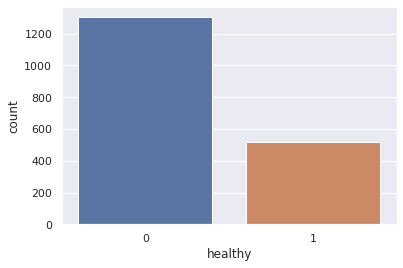

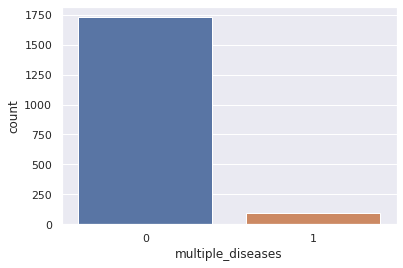

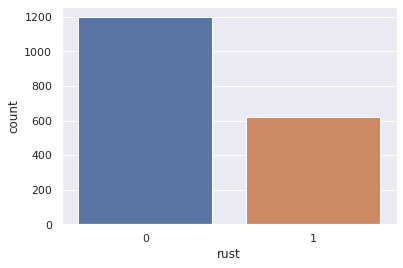

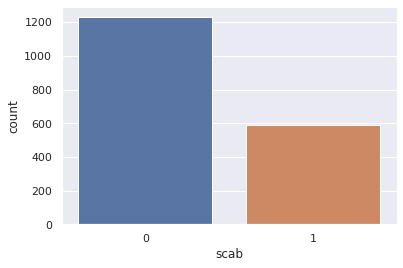

<Figure size 432x288 with 0 Axes>

In [0]:
for i in target:
  sns.countplot(df_train[i])
  fig = plt.figure()
  print(df_train[i].value_counts())

In [0]:
#dtypesの確認
print(pd.Series(df_train.dtypes).value_counts())
print(pd.Series(df_test.dtypes).value_counts())

int64     4
object    1
dtype: int64
object    1
dtype: int64


In [0]:
# 欠損地一つ以上のカラム
total_train = df_train.isnull().sum()
total_test = df_test.isnull().sum()
percent_train = (df_train.isnull().sum()/df_train.isnull().count())
percent_test = (df_test.isnull().sum()/df_test.isnull().count())
missing_data = pd.concat([total_train,total_test, percent_train, percent_test], axis=1, keys=['Total_train','Total_test', 'Percent_train',  'Percent_test'])
missing_data[(missing_data["Total_train"]>0) | (missing_data["Total_test"]>0)].sort_values("Total_train",ascending=False)

,Total_train,Total_test,Percent_train,Percent_test


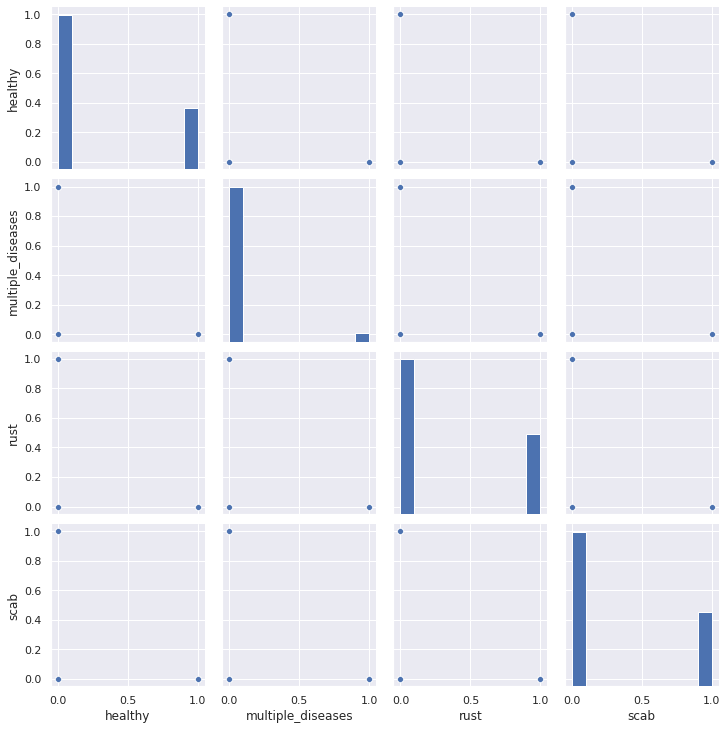

In [0]:
sns.pairplot(df_train)

### image_pathの読み込み

In [0]:
#今回はtrain_imgaeとtest_imageが同じファイルに入っている
image_path = "/content/images"
#trainデータの読み込み
df_train["image_path"] = image_path + "/" + df_train["image_id"] + ".jpg"

#testデータの読み込み
df_test["image_path"] = image_path + "/" + df_test["image_id"] + ".jpg"

In [0]:
df_test.head()

,image_id,image_path
0,Test_0,/content/images/Test_0.jpg
1,Test_1,/content/images/Test_1.jpg
2,Test_2,/content/images/Test_2.jpg
3,Test_3,/content/images/Test_3.jpg
4,Test_4,/content/images/Test_4.jpg


In [0]:
df_train[target].iloc[0]

healthy              0
scab                 1
multiple_diseases    0
rust                 0
Name: 0, dtype: int64

healthy              0
multiple_diseases    0
rust                 0
scab                 1
Name: 379, dtype: int64
Image Shape- (1365, 2048, 3)


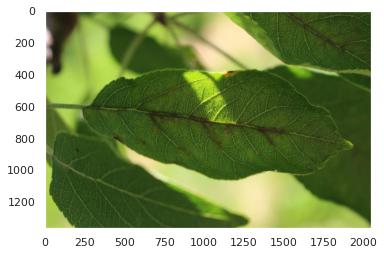

healthy              0
multiple_diseases    1
rust                 0
scab                 0
Name: 1173, dtype: int64
Image Shape- (1365, 2048, 3)


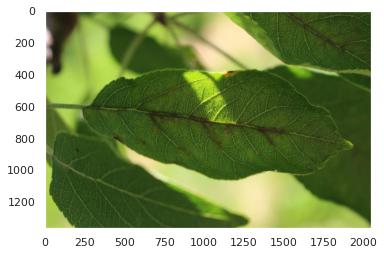

In [0]:
# 10番目のレコードの画像ファイルを読み込み(imreadの引数0⇒白黒,1⇒カラー)
n = 379
tmp_img = cv2.imread(df_train["image_path"][n],1)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

#データの表示
plt.imshow(tmp_img)
plt.grid(False)
print(df_train[target].iloc[n])
print("Image Shape-",tmp_img.shape)
plt.show()


# 10番目のレコードの画像ファイルを読み込み(imreadの引数0⇒白黒,1⇒カラー)
n = 1173
tmp_img = cv2.imread(df_train["image_path"][n],1)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

#データの表示
plt.imshow(tmp_img)
plt.grid(False)
print(df_train[target].iloc[n])
print("Image Shape-",tmp_img.shape)
plt.show()

In [0]:
tmp_img.shape

(1365, 2048, 3)

### ピクセルサイズの確認(一度のみ実行)

In [0]:
#train,numpy配列に変換しユニークをとる
%%time
shape_list_train = []
for i in range(len(df_train)):
  tmp_img = cv2.imread(df_train["image_path"][i],1)
  shape_list_train.append(tmp_img.shape)
print("shape",shape_list_train[0])
print("unique",np.unique(shape_list_train))

shape (1365, 2048, 3)
unique [   3 1365 2048]


In [0]:
#test,numpy配列に変換しユニークをとる
%%time
shape_list_test = []
for i in range(len(df_test)):
  tmp_img = cv2.imread(df_test["image_path"][i],1)
  shape_list_test.append(tmp_img.shape)
print("shape",shape_list_test[0])
print("unique",np.unique(shape_list_test))

shape (1365, 2048, 3)
unique [   3 1365 2048]


### データのリサンプル➡tf.datsetで.safful使う場合は不要

In [0]:
#単純にデータの順番をいれかえてるだけ(frac=1は全てのデータをもう一度リサンプル)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

healthy              1
scab                 0
multiple_diseases    0
rust                 0
Name: 1, dtype: int64
Image Shape- (1365, 2048, 3)


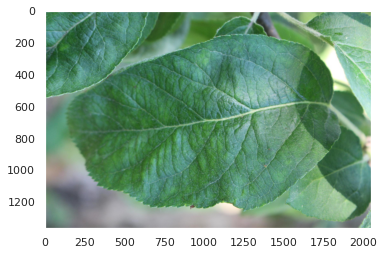

In [0]:
# 10番目のレコードの画像ファイルを読み込み(imreadの引数0⇒白黒,1⇒カラー)
tmp_img = cv2.imread(df_train["image_path"][1],1)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

#データの表示
plt.imshow(tmp_img)
plt.grid(False)
print(df_train[target].iloc[1])
print("Image Shape-",tmp_img.shape)
plt.show()

###重複イメージの削除
train379とtrain1173正解ラベルが異なっていたので、scabの方を削除multi1173を採用

In [0]:
#index379の行を削除 = 379．jpgの削除
df_train.drop(0,inplace=True)
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)
print(df_train.iloc[379,:])

(1820, 6)
image_id                                 Train_380
healthy                                          1
multiple_diseases                                0
rust                                             0
scab                                             0
image_path           /content/images/Train_380.jpg
Name: 379, dtype: object


### numpy配列化関数＋リサイズ＋正規化+BGRtoRGBしてセーブ(一度のみの実行。今回のリサイズは(244,244))⇒pickleに保存

In [0]:
#ilocにすべきか
df_train["image_path"][379]

'/content/images/Train_380.jpg'

In [0]:
#train,numpyに変換してデータフレームに格納(リサイズ)
def img_to_numpy(df_train,re_size = 244):
  datalist_train = []
  for i in range(len(df_train)):
    #ilocに変更すべきか
    tmp_img = cv2.imread(df_train["image_path"][i],1)
    tmp_img = cv2.resize(tmp_img, (re_size,re_size))
    tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
    datalist_train.append(tmp_img)
  #正規化
  datalist_train = np.array(datalist_train).astype("float32") /255
  print(datalist_train.shape)
  return datalist_train

In [0]:
#関数の実行
%%time
datalist_train =img_to_numpy(df_train,re_size = 244)
datalist_test = img_to_numpy(df_test,re_size = 244)

(1821, 244, 244, 3)
CPU times: user 55.8 s, sys: 566 ms, total: 56.4 s
Wall time: 56.4 s


In [0]:
#ピックるに保存
%%time
import pickle
save_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file_name = "datalist_train_np"
pickle.dump(datalist_train, open(os.path.join(save_path, file_name), 'wb'))
save_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file_name = "datalist_test_np"
pickle.dump(datalist_test, open(os.path.join(save_path, file_name), 'wb'))

CPU times: user 1.46 s, sys: 2.43 s, total: 3.89 s
Wall time: 35.9 s


### numpy配列のロード(244)

In [0]:
%%time
#numpyのロード
import pickle
load_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file_name = "datalist_train_np"
datalist_train = pickle.load(open(os.path.join(load_path, file_name), 'rb'))
load_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file_name = "datalist_test_np"
datalist_test = pickle.load(open(os.path.join(load_path, file_name), 'rb'))

CPU times: user 796 ms, sys: 2.59 s, total: 3.39 s
Wall time: 4.78 s


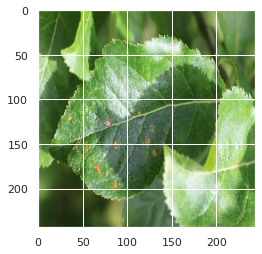

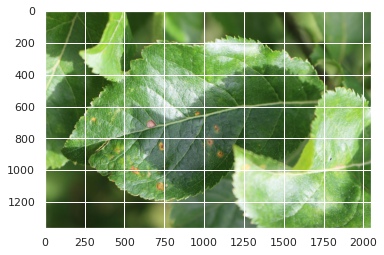

In [0]:
#再度表示、dfに格納する際にBGRで入れてるのでcv2で変換必須
plt.figure()
tmp_img = datalist_test[1]
# tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img)

plt.figure()
tmp_img = df_test["image_path"].iloc[1]
tmp_img = cv2.imread(tmp_img)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img)

In [0]:
#y_trainの取り出し
#今回はすでにエンコ(バイナリ変換)されている⇒値だけ抜けばいい
y_train_encorded = df_train.loc[:, 'healthy':'scab'].values
y_train_encorded = y_train_encorded.astype("float32")
datalist_train.shape,y_train_encorded.shape

((1820, 244, 244, 3), (1820, 4))

In [0]:
import gc
gc.collect()

7996

#PCA

In [0]:
#要変換:画像枚数×展開したナンパイ
datalist_pca = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
# デコード
y_train_decorded = np.argmax(y_train_encorded, axis=1)
print(datalist_pca.shape,y_train_decorded.shape)

NameError: ignored

In [0]:
from sklearn.decomposition import PCA
#2次元まで減らす
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(datalist_pca)
#ファイル数＊ファイル数になる
X_train_pca.shape

(1820, 2)

In [0]:
import gc
gc.collect()

2251

In [0]:
# import pickle
# save_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
# file_name = "datalist_train_pca.pkl"
# pickle.dump(datalist_train, open(os.path.join(save_path, file_name), 'wb'))

# import pickle
# load_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
# file_name = "datalist_train_pca.pkl"
# X_train_pca = pickle.load(open(os.path.join(load_path, file_name), 'rb'))

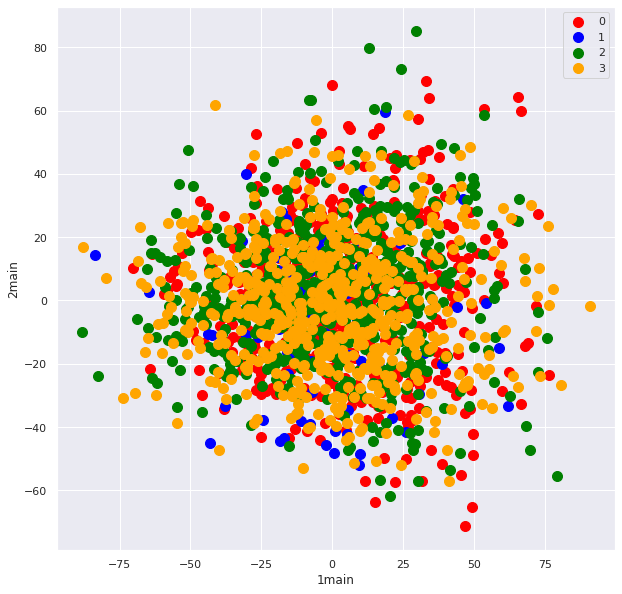

In [0]:
#プロット
group = y_train_decorded
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}

#第1主成分，第2主成分をそれぞれ横軸と縦軸に設定して散布図をかく
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel("1main")
plt.ylabel("2main")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_train_pca[ix,0], X_train_pca[ix,1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

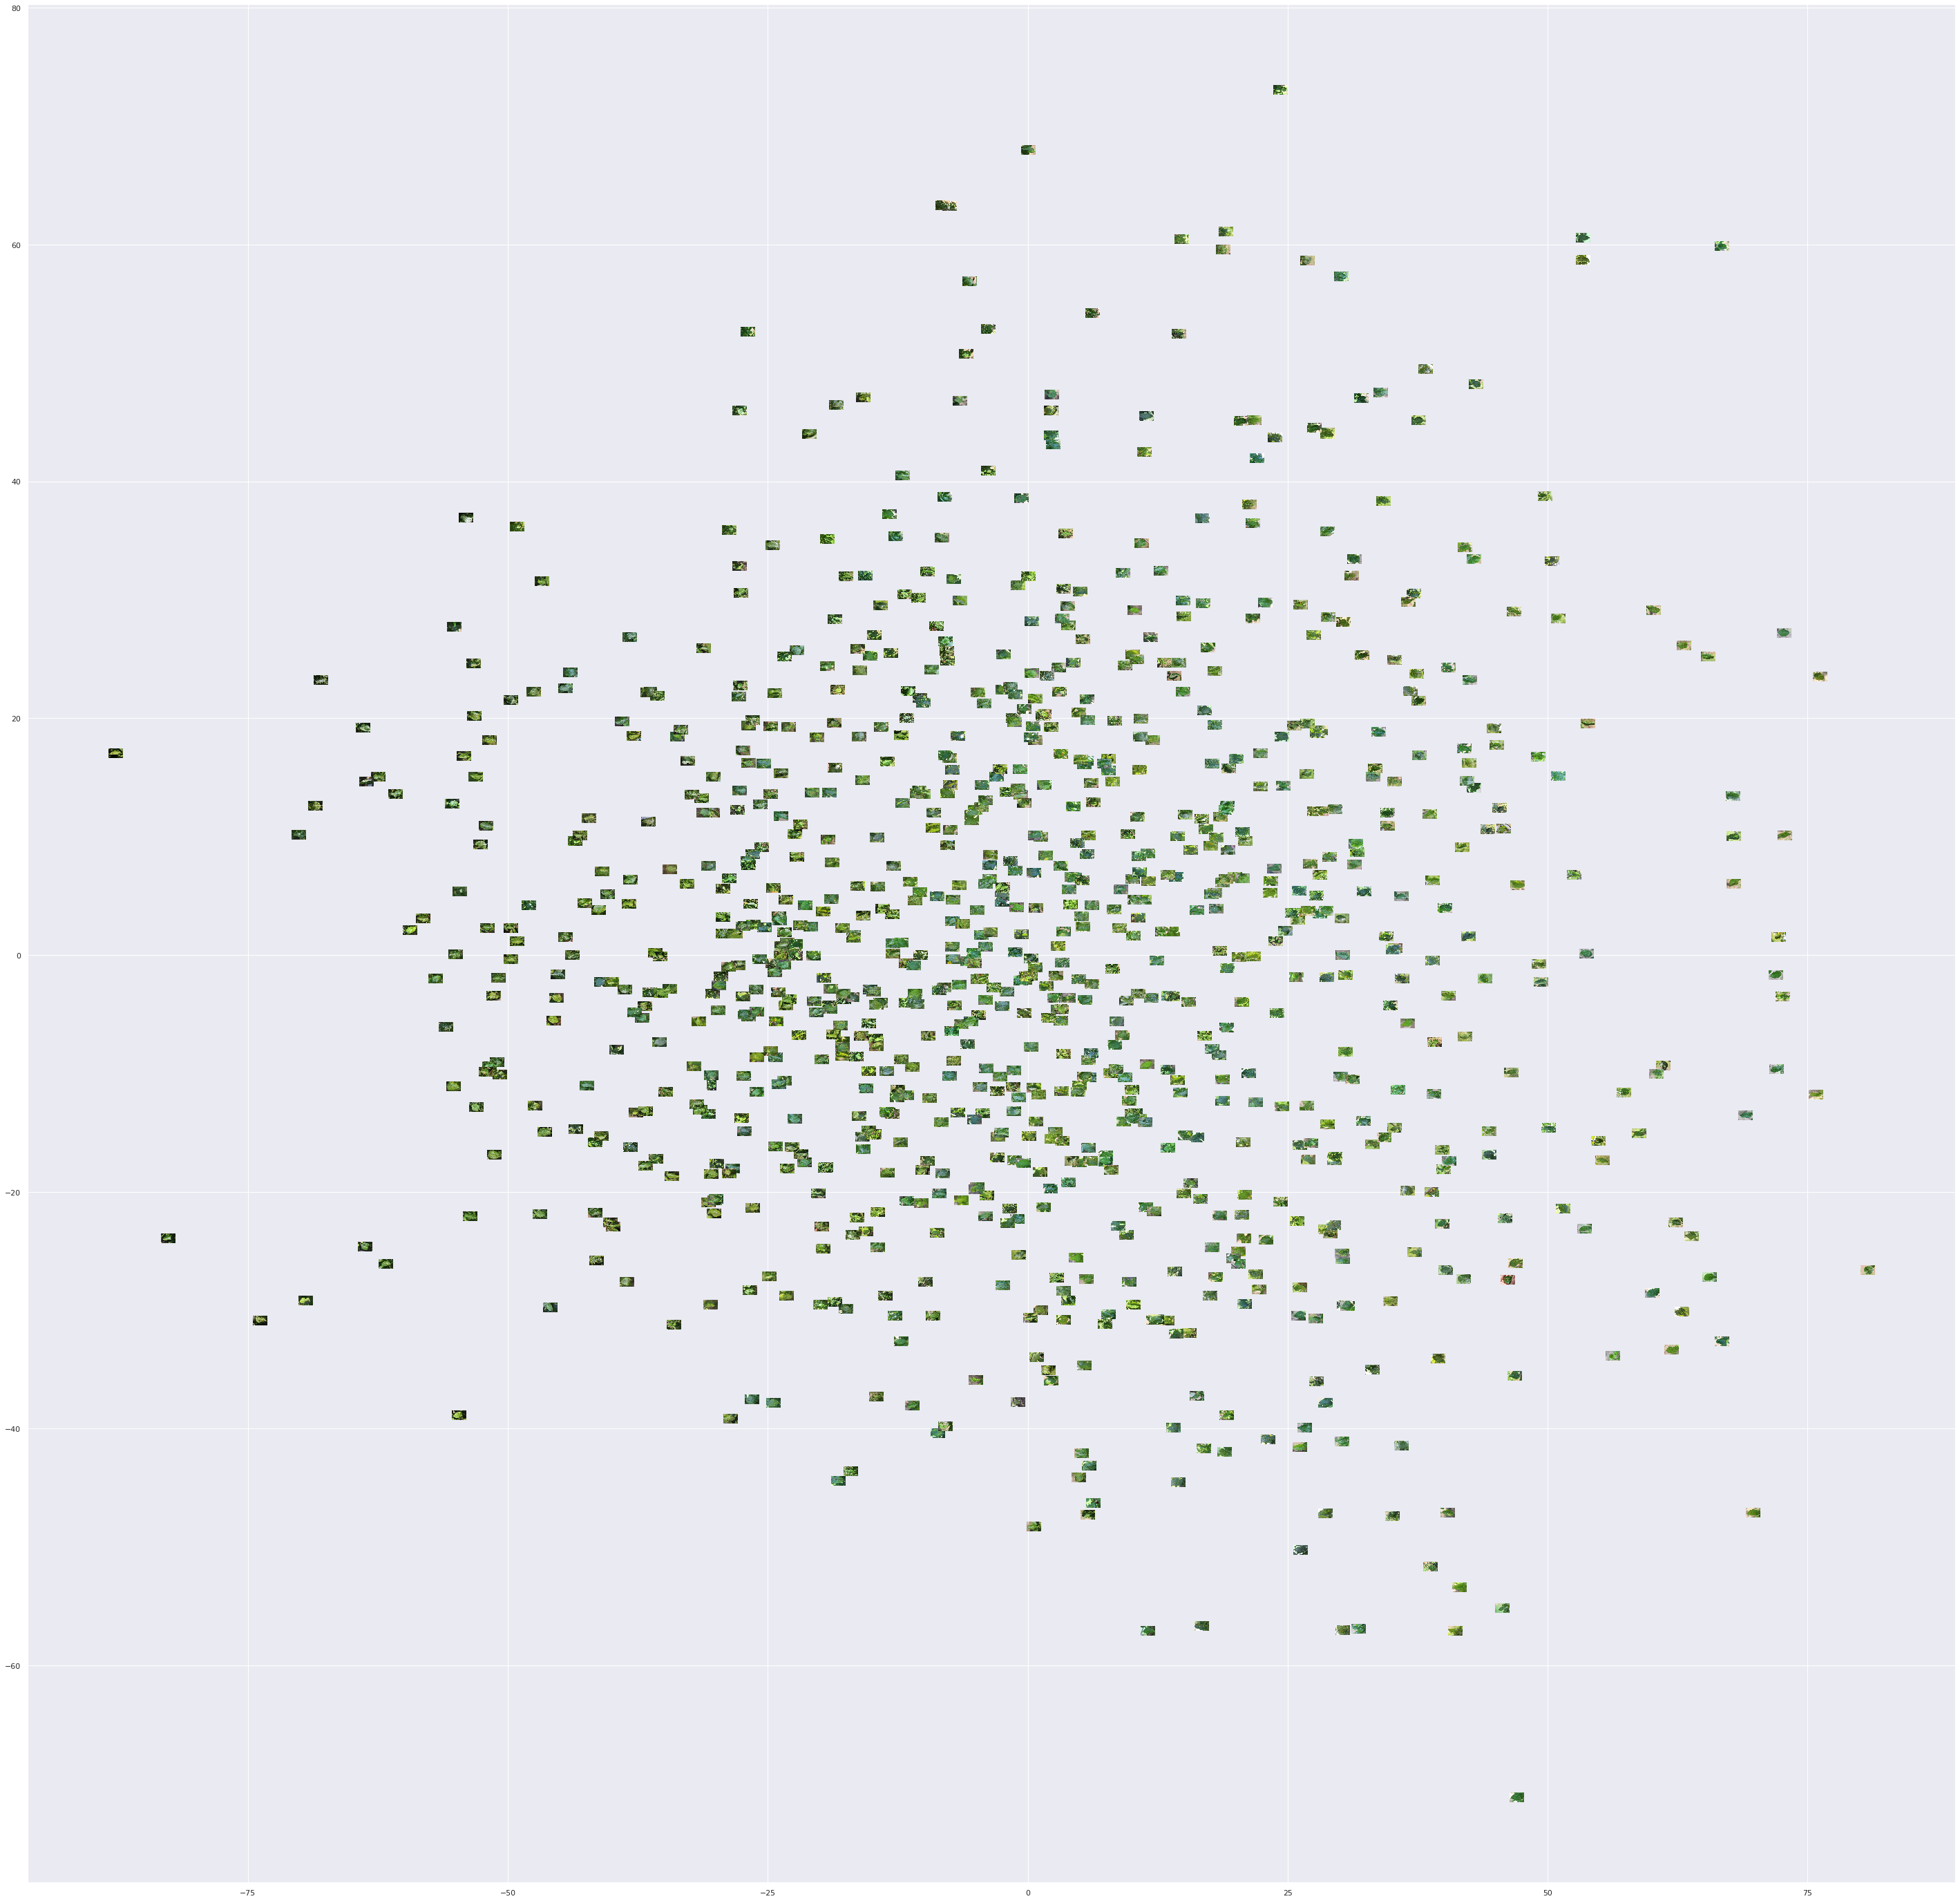

CPU times: user 2min 36s, sys: 20.3 s, total: 2min 56s
Wall time: 2min 56s


In [0]:
%%time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(plt.imread(str(p)), zoom=zoom) for p in image_list]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#プロット枚数=n-1
#zoomを小さくすれば、リサイズしなくてもなんとかなる。
n = 1000
fig, ax = plt.subplots(figsize=(50,50))
imscatter(X_train_pca[0:n,0], X_train_pca[0:n,1], df_train.image_path[0:n].tolist(), ax=ax, zoom=0.01)

plt.show()
import gc
gc.collect()

In [0]:
%%time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(plt.imread(str(p)), zoom=zoom) for p in image_list]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#プロット枚数=n-1
#zoomを小さくすれば、リサイズしなくてもなんとかなる。
n = 500
fig, ax = plt.subplots(figsize=(50,50))
imscatter(X_train_pca[0:n,0], X_train_pca[0:n,1], df_train.image_path[0:n].tolist(), ax=ax, zoom=0.05)

plt.show()
import gc
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

#t-SNE

In [0]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=688174f2d19a4377fb6f12ec53598bbe3d78efc33c8dea5fd04f2b3d9344526a
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [0]:
#要変換:画像枚数×展開したナンパイ
datalist_tsne = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
# デコード
y_train_decorded = np.argmax(y_train_encorded, axis=1)
print(datalist_pca.shape,y_train_decorded.shape)

(1820, 178608) (1820,)


In [0]:
%%time
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=4, perplexity=20) # 20が一番いい感じでした
X_train_tsne = tsne.fit_transform(datalist_tsne)

CPU times: user 20min 22s, sys: 1.35 s, total: 20min 24s
Wall time: 5min 24s


In [0]:
X_train_tsne.shape

(1820, 2)

In [0]:
import gc
gc.collect()

0

In [0]:
%%time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(plt.imread(str(p)), zoom=zoom) for p in image_list]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#プロット枚数=n-1
#zoomを小さくすれば、リサイズしなくてもなんとかなる。
n = 500
fig, ax = plt.subplots(figsize=(50,50))
imscatter(X_train_pca[0:n,0], X_train_pca[0:n,1], df_train.image_path[0:n].tolist(), ax=ax, zoom=0.05)

plt.show()
import gc
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

#kmenas

In [0]:
#要変換:画像枚数×展開したナンパイ
datalist_kmeans = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
# デコード
y_train_decorded = np.argmax(y_train_encorded, axis=1)
print(datalist_kmeans.shape,y_train_decorded.shape)

(1820, 178608) (1820,)


In [0]:
df_train_labeled = pd.concat([df_train,pd.DataFrame(y_train_decorded,columns=["y_label"])],axis=1)
df_train_labeled

,image_id,healthy,multiple_diseases,rust,scab,image_path,y_label
0,Train_1,0,1,0,0,/content/images/Train_1.jpg,1
1,Train_2,1,0,0,0,/content/images/Train_2.jpg,0
2,Train_3,0,0,1,0,/content/images/Train_3.jpg,2
3,Train_4,1,0,0,0,/content/images/Train_4.jpg,0
4,Train_5,1,0,0,0,/content/images/Train_5.jpg,0
...,...,...,...,...,...,...,...
1815,Train_1816,0,0,0,1,/content/images/Train_1816.jpg,3
1816,Train_1817,1,0,0,0,/content/images/Train_1817.jpg,0
1817,Train_1818,1,0,0,0,/content/images/Train_1818.jpg,0
1818,Train_1819,0,0,1,0,/content/images/Train_1819.jpg,2


In [0]:
print(datalist_train[df_train_labeled.y_label == 0].shape)
print(datalist_train[df_train_labeled.y_label == 1].shape)
print(datalist_train[df_train_labeled.y_label == 2].shape)
print(datalist_train[df_train_labeled.y_label == 3].shape)

(516, 244, 244, 3)
(91, 244, 244, 3)
(622, 244, 244, 3)
(591, 244, 244, 3)


In [0]:
healthy = datalist_train[df_train_labeled.y_label == 0]
multiple = datalist_train[df_train_labeled.y_label == 1]
rust = datalist_train[df_train_labeled.y_label == 2]
scab = datalist_train[df_train_labeled.y_label == 3]

In [0]:
datalist_train.shape

(1820, 244, 244, 3)

In [0]:
# k-means法によるクラスタリング
from sklearn.cluster import KMeans
def kme(datalist_train,n_clusters=3):
  datalist_kmeans = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
  kmeans = KMeans(n_clusters = n_clusters, max_iter = 100)
  kmeans.fit(datalist_kmeans)
  cluster_kmeans = kmeans.predict(datalist_kmeans)
  plt.figure(figsize=(8,8))
  plt.scatter(datalist_kmeans[:,0], datalist_kmeans[:,1], c = cluster_kmeans)
  plt.show()
  return cluster_kmeans

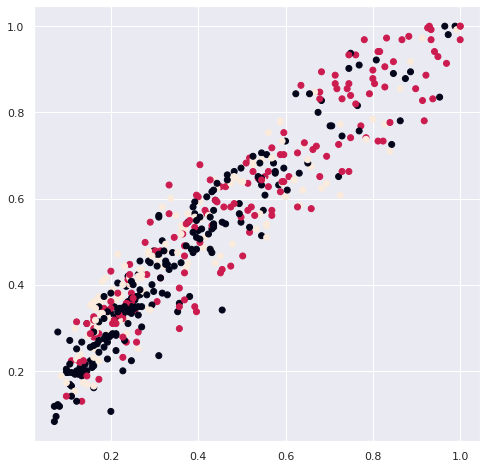

In [0]:
cluster_kmeans,km_predict = kme(healthy,n_clusters=3)

In [0]:
cluster_kmeans

array([2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 0, 2, 0,
       1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2,
       2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 2, 0,
       2, 0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1,
       0, 0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 1,
       0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 0, 0, 1,
       1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0,

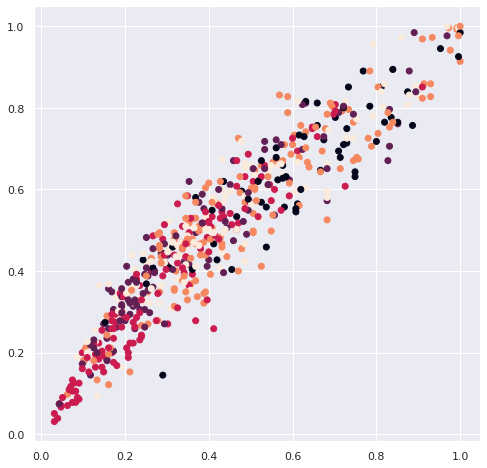

In [0]:
cluster_kmeans = kme(scab,n_clusters=5)

###DBSCAN

In [0]:
#要変換:画像枚数×展開したナンパイ
datalist_dbscan = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
# デコード
y_train_decorded = np.argmax(y_train_encorded, axis=1)
print(datalist_dbscan.shape,y_train_decorded.shape)

(1820, 178608) (1820,)


In [0]:
%%time
#epsの値が大きいと計算が終わらない
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 3, min_samples = 4)
cluster_dbscan = dbscan.fit_predict(datalist_dbscan)
cluster_dbscan

In [0]:
np.unique(cluster_dbscan)

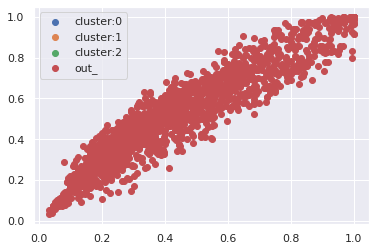

In [0]:
# 結果の可視化
cluster_0 = np.where(cluster_dbscan == 0)
cluster_1 = np.where(cluster_dbscan == 1)
cluster_2 = np.where(cluster_dbscan == 2)
out_ = np.where(cluster_dbscan==-1)

plt.scatter(datalist_dbscan[cluster_0, 0], datalist_dbscan[cluster_0, 1], label = "cluster:0")
plt.scatter(datalist_dbscan[cluster_1, 0], datalist_dbscan[cluster_1, 1], label = "cluster:1")
plt.scatter(datalist_dbscan[cluster_2, 0], datalist_dbscan[cluster_2, 1], label = "cluster:2")
plt.scatter(datalist_dbscan[out_,0], datalist_dbscan[out_,1], label = "out_")
plt.legend()
plt.show()

# ダウンサンプリング：アップサンプリング

In [0]:
cluster_kmeans

array([2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 0, 2, 0,
       1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2,
       2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 2, 0,
       2, 0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1,
       0, 0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 1,
       0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 0, 0, 1,
       1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0,

In [0]:
print(healthy[cluster_kmeans==0].shape)
print(healthy[cluster_kmeans==1].shape)
print(healthy[cluster_kmeans==2].shape)

(212, 244, 244, 3)
(168, 244, 244, 3)
(136, 244, 244, 3)


In [0]:
datalist_train

array([[[[0.80784315, 0.85882354, 0.85882354],
         [0.84313726, 0.8862745 , 0.9098039 ],
         [0.87058824, 0.9098039 , 0.9490196 ],
         ...,
         [0.8980392 , 1.        , 1.        ],
         [0.89411765, 0.99607843, 0.99215686],
         [0.8901961 , 0.98039216, 1.        ]],

        [[0.8156863 , 0.8627451 , 0.8627451 ],
         [0.85490197, 0.8980392 , 0.92156863],
         [0.8745098 , 0.9137255 , 0.9529412 ],
         ...,
         [0.92941177, 1.        , 1.        ],
         [0.92156863, 1.        , 0.99607843],
         [0.89411765, 0.99215686, 1.        ]],

        [[0.8235294 , 0.8666667 , 0.8666667 ],
         [0.85490197, 0.8980392 , 0.92156863],
         [0.8745098 , 0.9137255 , 0.9529412 ],
         ...,
         [0.94509804, 1.        , 1.        ],
         [0.94509804, 1.        , 1.        ],
         [0.9019608 , 1.        , 1.        ]],

        ...,

        [[0.827451  , 0.827451  , 0.57254905],
         [0.84313726, 0.84705883, 0.57254905]

In [0]:
def under_sampling_func(X,num,label) :


    # 群別の構成比を少数派の件数に乗じて群別の抽出件数を計算
    count_sum = X.groupby('Cluster').count().iloc[0:,0].as_matrix()
    ratio = count_sum / count_sum.sum()
    samp_num = np.round(ratio * num,0).astype(np.int32)

    # 群別にサンプリング処理を実施
    for i in np.arange(8) :
        tmp = X[X['Cluster']==i]
        if i == 0 :
            tmp1 = X.sample(samp_num[i],replace=True)
        else :
            tmp2 = X.sample(samp_num[i],replace=True)
            tmp1 = pd.concat([tmp1,tmp2])
    tmp1['Class'] = label
    return tmp1

In [0]:
# 群別の構成比を少数派の件数に乗じて群別の抽出件数を計算
count_sum = X.groupby('Cluster').count().iloc[0:,0].as_matrix()
    ratio = count_sum / count_sum.sum()
    samp_num = np.round(ratio * num,0).astype(np.int32)

    # 群別にサンプリング処理を実施
    for i in np.arange(8) :
        tmp = X[X['Cluster']==i]
        if i == 0 :
            tmp1 = X.sample(samp_num[i],replace=True)
        else :
            tmp2 = X.sample(samp_num[i],replace=True)
            tmp1 = pd.concat([tmp1,tmp2])
    tmp1['Class'] = label
    return tmp1

###smote＋ダウンサンプリング実験：train_Test_split

In [0]:
#valデータにsmoteをかけないように
datalist_train, X_val, y_train_encorded, y_val = train_test_split(datalist_train,y_train_encorded,
                                                  test_size= 0.2,random_state=42,stratify=y_train_encorded)

In [0]:
X_val.shape,y_train_encorded.sum(axis=0)

((364, 244, 244, 3), array([413.,  73., 497., 473.], dtype=float32))

### underサンプリング

In [0]:
from imblearn.under_sampling import RandomUnderSampler
datalist_smote = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
print(datalist_smote.shape)

#raitoで個数を指定
sampler = RandomUnderSampler(ratio={0:400, 1:73, 2:400, 3:400},random_state=42)
# downsampling
X_resampled, y_resampled = sampler.fit_resample(datalist_smote, y_train_encorded)

(1456, 178608)


In [0]:
X_resampled.shape,y_resampled.shape

((1273, 178608), (1273, 4))

In [0]:
y_resampled.sum(axis=0)

array([400,  73, 400, 400])

In [0]:
#smote用に一瞬置換
datalist_smote = X_resampled
y_train_encorded = y_resampled

### smote

In [0]:
#要変換
datalist_smote = datalist_train.reshape(datalist_train.shape[0], datalist_train.shape[1] * datalist_train.shape[2] * datalist_train.shape[3])
print(datalist_smote.shape)
#デコードは使わない
# y_train_decorded = np.argmax(y_train_encorded, axis=1)

IndexError: ignored

In [0]:
%%time
#X_trainは二次元配列(データ数*特徴量数しか受け付けないので要変換)
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_sample(datalist_smote, y_train_encorded)

#元のシェイプに変換
X_resampled = X_resampled.reshape(X_resampled.shape[0], datalist_train.shape[1], datalist_train.shape[2], datalist_train.shape[3])
print(X_resampled.shape,y_resampled.shape)

(1600, 244, 244, 3) (1600, 4)
CPU times: user 3.23 s, sys: 166 ms, total: 3.4 s
Wall time: 3.4 s


0    1200
1     400
Name: healthy, dtype: int64
0    1200
1     400
Name: multiple_diseases, dtype: int64
0    1200
1     400
Name: rust, dtype: int64
0    1200
1     400
Name: scab, dtype: int64


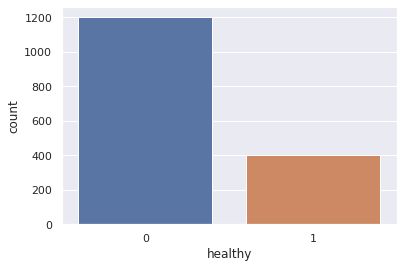

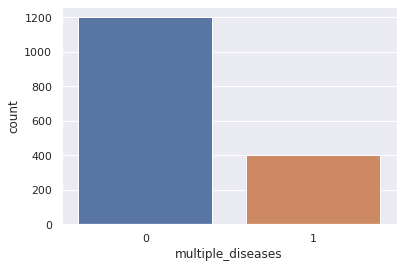

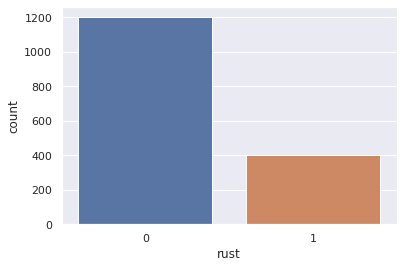

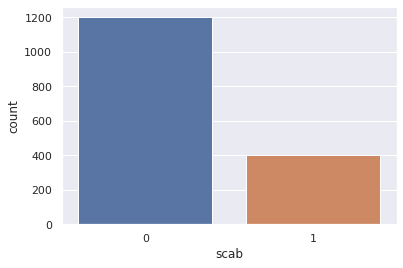

<Figure size 432x288 with 0 Axes>

In [0]:
#numpyをdfに変換
df_yre = pd.DataFrame(y_resampled,columns=targets)
for i in target:
  sns.countplot(df_yre[i])
  fig = plt.figure()
  print(df_yre[i].value_counts())

In [0]:
  import gc
  gc.collect()

0

healthy              0
multiple_diseases    0
rust                 1
scab                 0
Name: 1818, dtype: int64
Image Shape- (1365, 2048, 3)


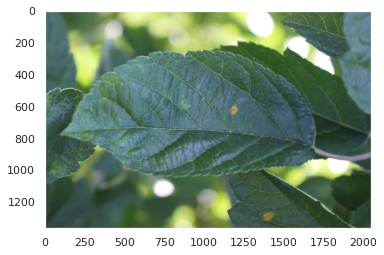

In [0]:
# ｎ番目のレコードの画像ファイルを読み込み(imreadの引数0⇒白黒,1⇒カラー)
n = 1818
tmp_img = cv2.imread(df_train["image_path"][n],1)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

#データの表示
plt.imshow(tmp_img)
plt.grid(False)
print(df_train[target].iloc[n])
print("Image Shape-",tmp_img.shape)
plt.show()

In [0]:
# n番目のレコードの画像ファイルを読み込み(imreadの引数0⇒白黒,1⇒カラー)
n = 2100
tmp_img = cv2.cvtColor(X_resampled[n], cv2.COLOR_BGR2RGB)
# tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

#データの表示
plt.imshow(tmp_img)
plt.grid(False)
print(df_yre[target].iloc[n])
print("Image Shape-",tmp_img.shape)
plt.show()

IndexError: ignored

### SMOTEデータの保存と読み込み

In [0]:
#保存
import pickle
save_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file = "X_resampled_down.pickle"
pickle.dump(X_resampled, open(os.path.join(save_path,file), 'wb'))

save_path = "/content/drive/My Drive/00Colab Notebooks/11Kaggle/Plant Pathology/pixel_scaled_npy"
file = "y_resampled_down.pickle"
pickle.dump(y_resampled, open(os.path.join(save_path,file), 'wb'))

In [0]:
import pickle
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/pixel_scaled_npy"
file = "X_resampled.pickle"
X_resampled= pickle.load(open(os.path.join(save_path,file), 'rb'))

save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/pixel_scaled_npy"
file = "y_resampled.pickle"
y_resampled= pickle.load(open(os.path.join(save_path,file), 'rb'))

### train_test_split

In [0]:
# X_train, X_val, y_train, y_val = train_test_split(datalist_train,y_train_encorded,
#                                                   test_size= 0.15,random_state=42,stratify=y_train_encorded)
# X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled,
#                                                   test_size= 0.15,random_state=42,stratify=y_resampled)
X_train, X_val, y_train, y_val = X_resampled,X_val,y_resampled,y_val

In [0]:
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

[400 400 400 400]
[103.  18. 125. 118.]
(1600, 244, 244, 3) (364, 244, 244, 3) (1600, 4) (364, 4)


In [0]:
#データの拡張
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  

[0. 0. 1. 0.]


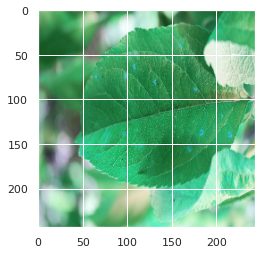

In [0]:
tmp_img = X_val[0]
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img)
print(y_val[0])

### smoteでtfデータセット

In [0]:
#代入
test_paths = df_test.image_path
train_paths, valid_paths, train_labels, valid_labels = X_train, X_val, y_train, y_val
train_paths.shape,valid_paths.shape

((1600, 244, 244, 3), (364, 244, 244, 3))

In [0]:
#decode_imageは省略
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Tensor("resize/Squeeze:0", shape=(244, 244, 3), dtype=float32)
label:None


# <font color= "DeepPink">3.tfデータセットの作成
https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
https://www.tensorflow.org/guide/data

In [0]:
y_train_encorded = df_train.loc[:, 'healthy':'scab'].values
y_train_encorded = y_train_encorded.astype("float32")

In [0]:
filenames = df_train.image_path
test_paths = df_test.image_path
labels = y_train_encorded
train_paths, valid_paths, train_labels, valid_labels = train_test_split(filenames,labels,
                                                  test_size= 0.15,random_state=42,stratify=labels)

In [0]:
print(train_labels.sum(axis=0))
print(valid_labels.sum(axis=0))

[438.  77. 529. 503.]
[78. 14. 93. 89.]


In [0]:
train_paths.shape,valid_paths.shape,train_labels.shape,valid_labels.shape

((1547,), (274,), (1547, 4), (274, 4))

In [0]:
#デコード、リサイズ,testdataのlabelはNone,labelは返さなくても消えない
def decode_image(filename, label=None, image_size=(244, 244)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    print(image)
    if label is None:
        print("label:None")
        return image
    else:
        print("label:Exist")
        return image, label
        

#データの水増し
def data_augment(image, label=None):
    seed = 42
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    # delta１でほぼ真っ白
    # image = tf.image.random_brightness(image, max_delta=0.5 ,seed=seed)
    # image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    #crop⇒トリミングするとinputsizeに違反するのでダメ！
    # image = tf.image.random_crop(image, size=[150, 150, 3], seed=seed)
    # image = tf.image.random_hue(image, max_delta=0.5, seed=seed)
    # #100が通常クオリティ
    # image = tf.image.random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=seed)
    # image = tf.image.random_saturation(image, lower=0.2, upper=1.8, seed=seed)
    # imgae = tf.image.rot90(image, k=1, name=None)

    if label is None:
        return image
    else:
        return image, label

In [0]:
BATCH_SIZE = 16
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#CPU,GPU関係
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Tensor("resize/Squeeze:0", shape=(244, 244, 3), dtype=float32)
label:Exist
Tensor("resize/Squeeze:0", shape=(244, 244, 3), dtype=float32)
label:Exist
Tensor("resize/Squeeze:0", shape=(244, 244, 3), dtype=float32)
label:None


### <font color="DeepPInk">tf.dataset使い方

- map関数と自作funcで処理が可能
- x,y両方をinputして作った場合、二変数のfor文で回すことができる

In [0]:
print(train_dataset.element_spec)
print(train_dataset)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>


In [0]:
train_dataset3 = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

aruyo
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(4,), dtype=float32)
Tensor("resize/Squeeze:0", shape=(224, 224, 3), dtype=float32)
label:Exist


In [0]:
#.repeat()で引数を指定していないので無限ループする
for i,j in train_dataset3:
  # print(i.numpy()[:5])
  k = j.numpy()
  print(k.shape)
  print(k[:5])

(16, 4)
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
(16, 4)
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
(16, 4)
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
(16, 4)
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
(16, 4)
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
(16, 4)
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
(16, 4)
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
(16, 4)
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
(16, 4)
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
(16, 4)
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
(16, 4)
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
(16, 4)
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 

KeyboardInterrupt: ignored

In [0]:
for i in test_dataset:
  k = i.numpy()
  print(k.shape)
  print(k)
  plt.imshow(k)
  break

In [0]:
for i in test_dataset:
  print(i.numpy()[0])
  # k = i.numpy()
  # print(k.shape)
  # print(k[:5])

ストリーミング出力は最後の 5000 行に切り捨てられました。
  [0.23529412 0.27450982 0.23137255]]]
[[[0.23060894 0.34901962 0.13965768]
  [0.19961427 0.3211829  0.09214079]
  [0.22395305 0.29136    0.13302666]
  ...
  [0.24313726 0.44313726 0.28235295]
  [0.23921569 0.43529412 0.28627452]
  [0.25882354 0.45490196 0.30588236]]

 [[0.15025894 0.2826997  0.0794308 ]
  [0.12922958 0.22709826 0.07280703]
  [0.48993728 0.6524391  0.39259508]
  ...
  [0.22661173 0.42661172 0.26582742]
  [0.246207   0.44228545 0.29326585]
  [0.25605056 0.45212898 0.30310938]]

 [[0.21640147 0.30778688 0.12263742]
  [0.12311958 0.14396796 0.07634498]
  [0.38266987 0.57896024 0.24822444]
  ...
  [0.24019888 0.44019887 0.27941456]
  [0.25716072 0.45323914 0.30421954]
  [0.2398273  0.43590572 0.28688613]]

 ...

 [[0.20857605 0.334902   0.20822246]
  [0.24999681 0.40060246 0.2467925 ]
  [0.11764706 0.2784314  0.11372549]
  ...
  [0.44111282 0.40189713 0.36660302]
  [0.40819737 0.37290326 0.34545228]
  [0.37920305 0.34390894 0.31645796]]

 [[

In [0]:
df_test.shape

(1821, 2)

# <font color= "DeepPink">3.モデルの作成

### <font color = "DeepOrange">モデル選択

In [0]:
#モデルの構築
from tensorflow.keras.regularizers import l2
filters = 32
reg = .0005
SIZE = 224
model = Sequential()

for i in range(5):
    model.add(Conv2D(filters, 3, kernel_regularizer=l2(reg), input_shape=(SIZE, SIZE, 3)))
    model.add(LeakyReLU())
    
    model.add(Conv2D(filters, 3, kernel_regularizer=l2(reg)))
    model.add(LeakyReLU())
    
    if i != 4:
        model.add(Conv2D(filters, 5, kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())
        
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    filters *= 2

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 220, 220, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 32)     

In [0]:
# optimizer
optimizer = Adam(lr=0.001)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [0]:
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=35)
rlr = ReduceLROnPlateau(patience=15, verbose=1)

#上書きしないように注意
file = "model_plant_1x1.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
callback_list = [early_stopping,rlr,mc]

### <font color = "DeepOrange">学習設定

In [0]:
#学習
batch_size = 32
epochs = 400

history = model.fit(
    train_dataset,
    # datagen.flow(X_train,y_train, batch_size=batch_size, seed=42),
     epochs = epochs, 
     validation_data = (X_val,y_val),
     verbose = 1, 
     steps_per_epoch=X_train.shape[0] // batch_size,
     callbacks=callback_list)

Epoch 1/400
48/48 [==============================] - ETA: 0s - loss: 2.8142 - accuracy: 0.2461
Epoch 00001: val_loss improved from inf to 3.53313, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_1x1.h5
48/48 [==============================] - 6s 119ms/step - loss: 2.8142 - accuracy: 0.2461 - val_loss: 3.5331 - val_accuracy: 0.1095 - lr: 0.0010
Epoch 2/400
48/48 [==============================] - ETA: 0s - loss: 2.7289 - accuracy: 0.2930
Epoch 00002: val_loss improved from 3.53313 to 3.12908, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_1x1.h5
48/48 [==============================] - 5s 97ms/step - loss: 2.7289 - accuracy: 0.2930 - val_loss: 3.1291 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 3/400
48/48 [==============================] - ETA: 0s - loss: 2.6175 - accuracy: 0.3203
Epoch 00003: val_loss improved from 3.12908 to 2.55065, saving model to /content/drive/My Drive/Colab Notebook

KeyboardInterrupt: ignored

### モデルの保存

In [0]:
#モデルのセーブ
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
file = "model_plant99.h5"
model.save(model=model, filepath=os.path.join(save_path,file), overwrite=True, include_optimizer=True)

### モデルのロード

In [0]:
#model関連
# model.save_weights("bb.h5")
# model.load_weights("bb.h5")
# model.get_weights()

In [0]:
#modelの削除
try:
  del model
  print('ロードの前に既存のmodelを消したよ')
except:
  print('modelという変数は定義されてないよ')

#モデルのロード
load_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
file = "model_plant_zx4.h5"
model = load_model(os.path.join(load_path,file), compile=True)

ロードの前に既存のmodelを消したよ


### 追加学習

In [0]:
### コールバックはロードされない
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=35)
rlr = ReduceLROnPlateau(patience=15, verbose=1)

#上書きしないように注意
file = "model_plant_zx3.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
callback_list = [early_stopping,rlr,mc]

In [0]:
#学習
EPOCHS = 400
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=callback_list,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/400
48/48 [==============================] - ETA: 0s - loss: 2.9899 - accuracy: 0.2786
Epoch 00001: val_loss did not improve from 2.54414
48/48 [==============================] - 18s 372ms/step - loss: 2.9899 - accuracy: 0.2786 - val_loss: 5.3151 - val_accuracy: 0.0730 - lr: 0.0010
Epoch 2/400
48/48 [==============================] - ETA: 0s - loss: 2.8328 - accuracy: 0.2949
Epoch 00002: val_loss did not improve from 2.54414
48/48 [==============================] - 17s 363ms/step - loss: 2.8328 - accuracy: 0.2949 - val_loss: 3.8179 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 3/400
48/48 [==============================] - ETA: 0s - loss: 2.6893 - accuracy: 0.3184
Epoch 00003: val_loss did not improve from 2.54414
48/48 [==============================] - 17s 352ms/step - loss: 2.6893 - accuracy: 0.3184 - val_loss: 2.5791 - val_accuracy: 0.4197 - lr: 0.0010
Epoch 4/400
48/48 [==============================] - ETA: 0s - loss: 2.6409 - accuracy: 0.3327
Epoch 00004: val_loss did not im

#### ★test_predict1

In [0]:
#コメントアウト忘れずに↓
# test_predicts = []
test_predict_x = model.predict(test_data)
test_predicts.append(test_predict_x)
print(len(test_predicts))

1


In [0]:
model.predict(X_train)

array([[2.2966820e-01, 9.5028572e-02, 1.7947027e-01, 4.9583289e-01],
       [3.2543883e-01, 8.5229300e-02, 1.6963167e-01, 4.1970024e-01],
       [2.8145691e-05, 7.4232570e-03, 9.9254709e-01, 1.5423396e-06],
       ...,
       [9.2854942e-05, 1.2080991e-02, 9.8781663e-01, 9.5872792e-06],
       [9.1915619e-01, 7.3710121e-03, 9.3192132e-03, 6.4153627e-02],
       [1.2638695e-05, 5.5027842e-03, 9.9448413e-01, 4.9919976e-07]],
      dtype=float32)

# <font color= "DeepPink">４.転移学習

### ●転移学習　Densnet

In [0]:
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.layers as L

SIZE = 244
optimizer = Adam(lr=0.001) 

# with strategy.scope():
model = tf.keras.Sequential([DenseNet121(input_shape=(SIZE, SIZE, 3),
                                          weights='imagenet',
                                          include_top=False),
                              L.GlobalAveragePooling2D(),
                              L.Dense(train_labels.shape[1],
                                      activation='softmax')])
    
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
model.layers[0].trainable = False
#レイヤー名を指定してもいい
# model.get_layer("densenet121").trainable = True

for i in model.layers:
  print(i.name,i.trainable) 

densenet121 False
global_average_pooling2d True
dense True


In [0]:
for i in model.layers:
  print(i.name,i.trainable) 

densenet121 False
global_average_pooling2d True
dense True


In [0]:
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
rlr = ReduceLROnPlateau(patience=8, verbose=1)

#上書きしないように注意
file = "model_plant_a1_ex.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
callback_list = [early_stopping,rlr,mc]

In [0]:
EPOCHS = 200
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=callback_list,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/200
12/12 [==============================] - ETA: 0s - accuracy: 0.7643 - loss: 0.6549
Epoch 00001: val_loss improved from inf to 51.80810, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 34s 3s/step - accuracy: 0.7643 - loss: 0.6549 - val_accuracy: 0.3285 - val_loss: 51.8081 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - ETA: 0s - accuracy: 0.8984 - loss: 0.3395
Epoch 00002: val_loss did not improve from 51.80810
12/12 [==============================] - 9s 780ms/step - accuracy: 0.8984 - loss: 0.3395 - val_accuracy: 0.2336 - val_loss: 64.5998 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9238 - loss: 0.2163
Epoch 00003: val_loss improved from 51.80810 to 25.27316, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/st


Epoch 00005: val_loss improved from 14.79656 to 12.31682, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9453 - loss: 0.1535 - val_accuracy: 0.4270 - val_loss: 12.3168 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9564 - loss: 0.1485WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00006: val_loss improved from 12.31682 to 7.76215, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9564 - loss: 0.1485 - val_accuracy: 0.4453 - val_loss: 7.7622 - lr: 0.0010
Epoch 7/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9583 - loss: 0.1337WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00007: val_loss improved from 7.76215 to 4.54120, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 14s 1s/step - accuracy: 0.9583 - loss: 0.1337 - val_accuracy: 0.4416 - val_loss: 4.5412 - lr: 0.0010
Epoch 8/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9727 - loss: 0.0907WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00008: val_loss did not improve from 4.54120
12/12 [==============================] - 10s 800ms/step - accuracy: 0.9727 - loss: 0.0907 - val_accuracy: 0.4453 - val_loss: 4.5825 - lr: 0.0010
Epoch 9/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9753 - loss: 0.0754WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00009: val_loss improved from 4.54120 to 2.66674, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9753 - loss: 0.0754 - val_accuracy: 0.5547 - val_loss: 2.6667 - lr: 0.0010
Epoch 10/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9701 - loss: 0.0824WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00010: val_loss improved from 2.66674 to 0.50077, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 14s 1s/step - accuracy: 0.9701 - loss: 0.0824 - val_accuracy: 0.8978 - val_loss: 0.5008 - lr: 0.0010
Epoch 11/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9661 - loss: 0.1011WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00011: val_loss did not improve from 0.50077
12/12 [==============================] - 9s 778ms/step - accuracy: 0.9661 - loss: 0.1011 - val_accuracy: 0.8504 - val_loss: 0.7242 - lr: 0.0010
Epoch 12/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9824 - loss: 0.0641WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00012: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 796ms/step - accuracy: 0.9824 - loss: 0.0641 - val_accuracy: 0.8759 - val_loss: 0.6986 - lr: 0.0010
Epoch 13/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9805 - loss: 0.0486WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00013: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 818ms/step - accuracy: 0.9805 - loss: 0.0486 - val_accuracy: 0.8978 - val_loss: 0.5283 - lr: 0.0010
Epoch 14/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9831 - loss: 0.0456WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00014: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 802ms/step - accuracy: 0.9831 - loss: 0.0456 - val_accuracy: 0.8869 - val_loss: 0.7873 - lr: 0.0010
Epoch 15/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9837 - loss: 0.0505WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00015: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 803ms/step - accuracy: 0.9837 - loss: 0.0505 - val_accuracy: 0.8467 - val_loss: 0.5392 - lr: 0.0010
Epoch 16/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9714 - loss: 0.0870WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00016: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 799ms/step - accuracy: 0.9714 - loss: 0.0870 - val_accuracy: 0.8321 - val_loss: 0.7176 - lr: 0.0010
Epoch 17/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9727 - loss: 0.0952WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00017: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 799ms/step - accuracy: 0.9727 - loss: 0.0952 - val_accuracy: 0.8431 - val_loss: 0.7020 - lr: 0.0010
Epoch 18/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9779 - loss: 0.0630WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: val_loss did not improve from 0.50077
12/12 [==============================] - 9s 788ms/step - accuracy: 0.9779 - loss: 0.0630 - val_accuracy: 0.7810 - val_loss: 1.1610 - lr: 0.0010
Epoch 19/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9811 - loss: 0.0553WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00019: val_loss did not improve from 0.50077
12/12 [==============================] - 10s 795ms/step - accuracy: 0.9811 - loss: 0.0553 - val_accuracy: 0.8613 - val_loss: 0.6663 - lr: 1.0000e-04
Epoch 20/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9954 - loss: 0.0199WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00020: val_loss improved from 0.50077 to 0.43746, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9954 - loss: 0.0199 - val_accuracy: 0.8978 - val_loss: 0.4375 - lr: 1.0000e-04
Epoch 21/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9941 - loss: 0.0246WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00021: val_loss improved from 0.43746 to 0.37239, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 18s 2s/step - accuracy: 0.9941 - loss: 0.0246 - val_accuracy: 0.9015 - val_loss: 0.3724 - lr: 1.0000e-04
Epoch 22/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0148WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00022: val_loss improved from 0.37239 to 0.30523, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0148 - val_accuracy: 0.9051 - val_loss: 0.3052 - lr: 1.0000e-04
Epoch 23/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0118WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00023: val_loss improved from 0.30523 to 0.25407, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 14s 1s/step - accuracy: 0.9980 - loss: 0.0118 - val_accuracy: 0.9197 - val_loss: 0.2541 - lr: 1.0000e-04
Epoch 24/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0074WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00024: val_loss improved from 0.25407 to 0.22327, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0074 - val_accuracy: 0.9307 - val_loss: 0.2233 - lr: 1.0000e-04
Epoch 25/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0091WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00025: val_loss improved from 0.22327 to 0.18969, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0091 - val_accuracy: 0.9416 - val_loss: 0.1897 - lr: 1.0000e-04
Epoch 26/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9967 - loss: 0.0145WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00026: val_loss improved from 0.18969 to 0.15751, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9967 - loss: 0.0145 - val_accuracy: 0.9526 - val_loss: 0.1575 - lr: 1.0000e-04
Epoch 27/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0124WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00027: val_loss improved from 0.15751 to 0.13528, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9974 - loss: 0.0124 - val_accuracy: 0.9526 - val_loss: 0.1353 - lr: 1.0000e-04
Epoch 28/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9961 - loss: 0.0140WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00028: val_loss did not improve from 0.13528
12/12 [==============================] - 10s 802ms/step - accuracy: 0.9961 - loss: 0.0140 - val_accuracy: 0.9599 - val_loss: 0.1353 - lr: 1.0000e-04
Epoch 29/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0086WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00029: val_loss did not improve from 0.13528
12/12 [==============================] - 10s 803ms/step - accuracy: 0.9980 - loss: 0.0086 - val_accuracy: 0.9526 - val_loss: 0.1504 - lr: 1.0000e-04
Epoch 30/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0075WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00030: val_loss did not improve from 0.13528
12/12 [==============================] - 10s 810ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9526 - val_loss: 0.1450 - lr: 1.0000e-04
Epoch 31/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0048WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00031: val_loss improved from 0.13528 to 0.13428, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9526 - val_loss: 0.1343 - lr: 1.0000e-04
Epoch 32/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0089WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00032: val_loss did not improve from 0.13428
12/12 [==============================] - 10s 863ms/step - accuracy: 0.9987 - loss: 0.0089 - val_accuracy: 0.9562 - val_loss: 0.1360 - lr: 1.0000e-04
Epoch 33/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0052WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00033: val_loss improved from 0.13428 to 0.13021, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9526 - val_loss: 0.1302 - lr: 1.0000e-04
Epoch 34/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0068WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00034: val_loss improved from 0.13021 to 0.12886, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9635 - val_loss: 0.1289 - lr: 1.0000e-04
Epoch 35/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0049WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00035: val_loss did not improve from 0.12886
12/12 [==============================] - 10s 801ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9562 - val_loss: 0.1321 - lr: 1.0000e-04
Epoch 36/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0058WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00036: val_loss improved from 0.12886 to 0.12543, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.9599 - val_loss: 0.1254 - lr: 1.0000e-04
Epoch 37/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0053WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00037: val_loss improved from 0.12543 to 0.11668, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0053 - val_accuracy: 0.9635 - val_loss: 0.1167 - lr: 1.0000e-04
Epoch 38/200
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0025WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00038: val_loss improved from 0.11668 to 0.11167, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9599 - val_loss: 0.1117 - lr: 1.0000e-04
Epoch 39/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0104WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00039: val_loss improved from 0.11167 to 0.11075, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9980 - loss: 0.0104 - val_accuracy: 0.9672 - val_loss: 0.1108 - lr: 1.0000e-04
Epoch 40/200
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0025WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00040: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 812ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9672 - val_loss: 0.1197 - lr: 1.0000e-04
Epoch 41/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0047WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00041: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 823ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9672 - val_loss: 0.1212 - lr: 1.0000e-04
Epoch 42/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0044WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00042: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 806ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9672 - val_loss: 0.1192 - lr: 1.0000e-04
Epoch 43/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0047WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00043: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 822ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.9672 - val_loss: 0.1169 - lr: 1.0000e-04
Epoch 44/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0049WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00044: val_loss did not improve from 0.11075
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9672 - val_loss: 0.1145 - lr: 1.0000e-04
Epoch 45/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0031WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00045: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 811ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9635 - val_loss: 0.1140 - lr: 1.0000e-04
Epoch 46/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0029WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00046: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 817ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9635 - val_loss: 0.1150 - lr: 1.0000e-04
Epoch 47/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0030WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00047: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 821ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9672 - val_loss: 0.1158 - lr: 1.0000e-04
Epoch 48/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0029WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00048: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 818ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9672 - val_loss: 0.1150 - lr: 1.0000e-05
Epoch 49/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0038WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00049: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 816ms/step - accuracy: 0.9987 - loss: 0.0038 - val_accuracy: 0.9672 - val_loss: 0.1137 - lr: 1.0000e-05
Epoch 50/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0055WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00050: val_loss did not improve from 0.11075
12/12 [==============================] - 10s 820ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.9672 - val_loss: 0.1124 - lr: 1.0000e-05
Epoch 51/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0034WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00051: val_loss improved from 0.11075 to 0.11070, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0034 - val_accuracy: 0.9672 - val_loss: 0.1107 - lr: 1.0000e-05
Epoch 52/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0028WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00052: val_loss improved from 0.11070 to 0.11064, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9672 - val_loss: 0.1106 - lr: 1.0000e-05
Epoch 53/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0061WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00053: val_loss improved from 0.11064 to 0.10943, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.9672 - val_loss: 0.1094 - lr: 1.0000e-05
Epoch 54/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0050WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00054: val_loss improved from 0.10943 to 0.10749, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9672 - val_loss: 0.1075 - lr: 1.0000e-05
Epoch 55/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0035WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00055: val_loss improved from 0.10749 to 0.10690, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9672 - val_loss: 0.1069 - lr: 1.0000e-05
Epoch 56/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0049WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00056: val_loss improved from 0.10690 to 0.10677, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 16s 1s/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9672 - val_loss: 0.1068 - lr: 1.0000e-05
Epoch 57/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0022WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00057: val_loss improved from 0.10677 to 0.10658, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9672 - val_loss: 0.1066 - lr: 1.0000e-05
Epoch 58/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0027WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00058: val_loss did not improve from 0.10658
12/12 [==============================] - 10s 798ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9672 - val_loss: 0.1069 - lr: 1.0000e-05
Epoch 59/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0074WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00059: val_loss did not improve from 0.10658
12/12 [==============================] - 10s 802ms/step - accuracy: 0.9974 - loss: 0.0074 - val_accuracy: 0.9672 - val_loss: 0.1071 - lr: 1.0000e-05
Epoch 60/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0030WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00060: val_loss did not improve from 0.10658
12/12 [==============================] - 10s 802ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9672 - val_loss: 0.1074 - lr: 1.0000e-05
Epoch 61/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0037WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00061: val_loss improved from 0.10658 to 0.10567, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.9672 - val_loss: 0.1057 - lr: 1.0000e-05
Epoch 62/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0033WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00062: val_loss did not improve from 0.10567
12/12 [==============================] - 10s 798ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9672 - val_loss: 0.1067 - lr: 1.0000e-05
Epoch 63/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0060WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00063: val_loss improved from 0.10567 to 0.10488, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.9672 - val_loss: 0.1049 - lr: 1.0000e-05
Epoch 64/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0018WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00064: val_loss improved from 0.10488 to 0.10398, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9672 - val_loss: 0.1040 - lr: 1.0000e-05
Epoch 65/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0023WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00065: val_loss improved from 0.10398 to 0.10274, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9672 - val_loss: 0.1027 - lr: 1.0000e-05
Epoch 66/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0039WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00066: val_loss improved from 0.10274 to 0.10253, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9672 - val_loss: 0.1025 - lr: 1.0000e-05
Epoch 67/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0023WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00067: val_loss did not improve from 0.10253
12/12 [==============================] - 10s 807ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9672 - val_loss: 0.1027 - lr: 1.0000e-05
Epoch 68/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0034WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00068: val_loss improved from 0.10253 to 0.10243, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9980 - loss: 0.0034 - val_accuracy: 0.9672 - val_loss: 0.1024 - lr: 1.0000e-05
Epoch 69/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0022WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00069: val_loss did not improve from 0.10243
12/12 [==============================] - 10s 807ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9672 - val_loss: 0.1031 - lr: 1.0000e-05
Epoch 70/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0037WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00070: val_loss did not improve from 0.10243
12/12 [==============================] - 10s 823ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9672 - val_loss: 0.1032 - lr: 1.0000e-05
Epoch 71/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0032WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00071: val_loss did not improve from 0.10243
12/12 [==============================] - 16s 1s/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9672 - val_loss: 0.1030 - lr: 1.0000e-05
Epoch 72/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0028WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00072: val_loss did not improve from 0.10243
12/12 [==============================] - 10s 820ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9672 - val_loss: 0.1032 - lr: 1.0000e-05
Epoch 73/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0021WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00073: val_loss improved from 0.10243 to 0.10239, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9672 - val_loss: 0.1024 - lr: 1.0000e-05
Epoch 74/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0034WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00074: val_loss improved from 0.10239 to 0.10089, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_a1_ex.h5
12/12 [==============================] - 15s 1s/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9672 - val_loss: 0.1009 - lr: 1.0000e-05
Epoch 75/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0035WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00075: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 792ms/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9672 - val_loss: 0.1018 - lr: 1.0000e-05
Epoch 76/200
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0019WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00076: val_loss did not improve from 0.10089
12/12 [==============================] - 9s 785ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9672 - val_loss: 0.1029 - lr: 1.0000e-05
Epoch 77/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0027WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00077: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 829ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9672 - val_loss: 0.1032 - lr: 1.0000e-05
Epoch 78/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0025WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00078: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 821ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9672 - val_loss: 0.1027 - lr: 1.0000e-05
Epoch 79/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0026WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00079: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 804ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9672 - val_loss: 0.1015 - lr: 1.0000e-05
Epoch 80/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0057WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00080: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 796ms/step - accuracy: 0.9987 - loss: 0.0057 - val_accuracy: 0.9672 - val_loss: 0.1013 - lr: 1.0000e-05
Epoch 81/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0071WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00081: val_loss did not improve from 0.10089
12/12 [==============================] - 11s 909ms/step - accuracy: 0.9980 - loss: 0.0071 - val_accuracy: 0.9672 - val_loss: 0.1029 - lr: 1.0000e-05
Epoch 82/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0035WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00082: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 835ms/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9672 - val_loss: 0.1028 - lr: 1.0000e-05
Epoch 83/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0030WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00083: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 832ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9672 - val_loss: 0.1026 - lr: 1.0000e-06
Epoch 84/200
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0016WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00084: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 800ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9672 - val_loss: 0.1031 - lr: 1.0000e-06
Epoch 85/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0033WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00085: val_loss did not improve from 0.10089
12/12 [==============================] - 10s 816ms/step - accuracy: 0.9980 - loss: 0.0033 - val_accuracy: 0.9672 - val_loss: 0.1035 - lr: 1.0000e-06
Epoch 86/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0021WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00086: val_loss did not improve from 0.10089
12/12 [==============================] - 9s 787ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9672 - val_loss: 0.1029 - lr: 1.0000e-06
Epoch 87/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0027WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00087: val_loss did not improve from 0.10089
12/12 [==============================] - 9s 787ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9672 - val_loss: 0.1030 - lr: 1.0000e-06
Epoch 88/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0027WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00088: val_loss did not improve from 0.10089
12/12 [==============================] - 9s 778ms/step - accuracy: 0.9987 - loss: 0.0027 - val_accuracy: 0.9672 - val_loss: 0.1034 - lr: 1.0000e-06
Epoch 89/200
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0033WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f0e77f41a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.



Epoch 00089: val_loss did not improve from 0.10089
12/12 [==============================] - 9s 787ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9672 - val_loss: 0.1024 - lr: 1.0000e-06


#### ★test_predict1

In [0]:
#コメントアウト忘れずに↓
test_predicts = []
test_data = datalist_test
test_predict_x = model.predict(test_data)
test_predicts.append(test_predict_x)
print(len(test_predicts))

1


### ●転移学習 VGG１６　(https://qiita.com/hiraku00/items/66a3606af3b2eed57778)

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
SIZE=244
#include_top : 出力層側にある3つの全結合層(Fully Connected層)を含むかどうか。今回はFC層を独自に用意False
#⇒FC層を学習させることを転移学習というたぶん、、、(ファインチューニングは全ての層を微調整する？)
#weights : VGG16の重みの種類。None(ランダム初期化)か'imagenet' (ImageNetで学習した重み)のどちらか
#input_shape : include_topがFalseの場合のみ指定可能 (そうでないときは入力のshapeは(224, 224, 3)。正確に3つの入力チャンネルをもつ必要があり、width とheightは48以上にする必要がある
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(SIZE, SIZE, 3)   
)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [0]:
top_model = Sequential()
#VGG16の最終層のshape
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(y_train.shape[1], activation='softmax'))

In [0]:
# combine models
from tensorflow.keras.models import Model
model = Model(
    inputs=vgg16_model.input,
    outputs=top_model(vgg16_model.output)
)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [0]:
# 重みの固定
for layer in model.layers[:19]:
    layer.trainable = False
#凍結層の確認
for i in model.layers:
  print(i.name,i.trainable)

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
sequential_4 True


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [0]:
# optimizer
optimizer = SGD(lr=1e-4, momentum=0.9)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [0]:
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
rlr = ReduceLROnPlateau(patience=10, verbose=15)

#上書きしないように注意
file = "model_plant_vgg_tg3.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
callback_list = [early_stopping,rlr,mc]

In [0]:
EPOCHS = 400
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=callback_list,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/400
96/96 [==============================] - ETA: 0s - loss: 1.3138 - accuracy: 0.3581WARNING:tensorflow:Model was constructed with shape (None, 244, 244, 3) for input Tensor("input_2:0", shape=(None, 244, 244, 3), dtype=float32), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 00001: val_loss improved from inf to 1.21528, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_vgg_tg3.h5
96/96 [==============================] - 32s 333ms/step - loss: 1.3138 - accuracy: 0.3581 - val_loss: 1.2153 - val_accuracy: 0.4307 - lr: 1.0000e-04
Epoch 2/400
96/96 [==============================] - ETA: 0s - loss: 1.1959 - accuracy: 0.4219
Epoch 00002: val_loss improved from 1.21528 to 1.19895, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_vgg_tg3.h5
96/96 [==============================] - 32s 338ms/step - loss: 1.1959 - accuracy: 0.4219 - val_loss: 1.1989 - val_

#### ★test_predict2

In [0]:
#コメントアウト忘れずに↓
test_predicts = []
test_data = datalist_test
test_predict_x = model.predict(test_data)
test_predicts.append(test_predict_x)
print(len(test_predicts))

KeyboardInterrupt: ignored

### ●転移学習 VGG１６　vol2

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
SIZE=244
#include_top : 出力層側にある3つの全結合層(Fully Connected層)を含むかどうか。今回はFC層を独自に用意False
#⇒FC層を学習させることを転移学習というたぶん、、、(ファインチューニング)
#weights : VGG16の重みの種類。None(ランダム初期化)か'imagenet' (ImageNetで学習した重み)のどちらか
#input_shape : include_topがFalseの場合のみ指定可能 (そうでないときは入力のshapeは(224, 224, 3)。正確に3つの入力チャンネルをもつ必要があり、width とheightは48以上にする必要がある
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(SIZE, SIZE, 3)   
)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [0]:
top_model = Sequential()
#VGG16の最終層のshape
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(y_train.shape[1], activation='softmax'))

In [0]:
# combine models
from tensorflow.keras.models import Model
model = Model(
    inputs=vgg16_model.input,
    outputs=top_model(vgg16_model.output)
)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [0]:
# 重みの固定
for layer in model.layers[:15]:
    layer.trainable = False
#凍結層の確認
for i in model.layers:
  print(i.name,i.trainable)

input_6 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
sequential_5 True


In [0]:
# optimizer
optimizer = SGD(lr=1e-4, momentum=0.9)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [0]:
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
rlr = ReduceLROnPlateau(patience=10, verbose=15)

#上書きしないように注意
file = "model_plant_vgg_smote1.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
callback_list = [early_stopping,rlr,mc]

In [0]:
EPOCHS = 200
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=callback_list,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 1.1719 - accuracy: 0.4956
Epoch 00001: val_loss did not improve from 1.34478
100/100 [==============================] - 7s 71ms/step - loss: 1.1719 - accuracy: 0.4956 - val_loss: 1.4037 - val_accuracy: 0.2747 - lr: 1.0000e-04
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 1.1208 - accuracy: 0.5106
Epoch 00002: val_loss improved from 1.34478 to 1.30227, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_vgg_smote1.h5
100/100 [==============================] - 7s 71ms/step - loss: 1.1208 - accuracy: 0.5106 - val_loss: 1.3023 - val_accuracy: 0.3132 - lr: 1.0000e-04
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 1.1166 - accuracy: 0.5150
Epoch 00003: val_loss did not improve from 1.30227
100/100 [==============================] - 7s 71ms/step - loss: 1.1166 - accuracy: 0.5150 - val_loss: 1.3439 - val_accuracy: 0.3104 - lr: 1.0

#### ★test_predict2

In [0]:
#ロード
#modelの削除
try:
  del model
  print('ロードの前に既存のmodelを消したよ')
except:
  print('modelという変数は定義されてないよ')

#モデルのロード
load_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
file = "model_plant_vgg_smote1.h5"
model = load_model(os.path.join(load_path,file), compile=True)

In [0]:
def decode_image(filename, label=None, image_size=(244, 244)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    print(image)
    if label is None:
        print("label:None")
        return image
    else:
        print("label:Exist")
        return image, label

In [0]:
#test_dataだけ作成
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE
test_paths = df_test.image_path
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Tensor("truediv:0", shape=(244, 244, 3), dtype=float32)
label:None


In [0]:
#コメントアウト忘れずに↓
test_predicts = []
test_predict_x = model.predict(test_dataset)
test_predicts.append(test_predict_x)
print(len(test_predicts))

1


### ●転移学習 EfficentNet
保存済みのEfficientNetのモデルをロードする際には、pipinstallとimport efnを忘れずに

In [0]:
!pip install -U git+https://github.com/qubvel/efficientnet
# !pip install -U efficientnet
# sys.path.append("/content/drive/My Drive/Colab Notebooks/03gitclone/efficientnet_keras_transfer_learning")

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-iuhjc_ln
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-iuhjc_ln
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18327 sha256=48220863a44ae982547243f3e36c4ecbecfce69bedb3d05cbb9761662452a0e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-iv6m0_22/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [0]:
# import efficientnet
# from efficientnet import EfficientNetB0 as efn
import efficientnet.tfkeras as efn

In [0]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([efn.EfficientNetB7(input_shape=(244, 244, 3),
                                                weights='imagenet',
                                                include_top=False),
                              L.GlobalAveragePooling2D(),
                              L.Dense(train_labels.shape[1],
                                      activation='softmax')])


    
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 8, 8, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


In [0]:
#重みの固定
for i,layer in enumerate(model.layers):
  print(i)
  if i < 1:
    layer.trainable = False
  else:
    layer.trainable = True
#凍結層の確認
for i in model.layers:
  print(i.name,i.trainable)

0
1
2
efficientnet-b7 False
global_average_pooling2d_1 True
dense_1 True


In [0]:
# callbacksの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
rlr = ReduceLROnPlateau(patience=15, verbose=8)

#上書きしないように注意
file = "model_plant_ef_tfdt1.h5"
save_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
save_path = os.path.join(save_path,file)
if os.path.exists(save_path):
  print("Warning:上書きされちゃうよ:チェックポイントがセットされてないよ")
else:
  mc = ModelCheckpoint(filepath=save_path, save_best_only=True,verbose=1)

# Callbacksまとめ
# callback_list = [early_stopping,rlr,mc]
callback_list = [early_stopping,mc]

In [0]:
EPOCHS = 400
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=callback_list,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/400
37/37 [==============================] - ETA: 0s - loss: 1.2125 - categorical_accuracy: 0.5726
Epoch 00001: val_loss improved from inf to 5.57785, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_ef_tfdt1.h5
37/37 [==============================] - 34s 928ms/step - loss: 1.2125 - categorical_accuracy: 0.5726 - val_loss: 5.5778 - val_categorical_accuracy: 0.5549
Epoch 2/400
37/37 [==============================] - ETA: 0s - loss: 0.7374 - categorical_accuracy: 0.7314
Epoch 00002: val_loss improved from 5.57785 to 2.06968, saving model to /content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/model_plant_ef_tfdt1.h5
37/37 [==============================] - 28s 762ms/step - loss: 0.7374 - categorical_accuracy: 0.7314 - val_loss: 2.0697 - val_categorical_accuracy: 0.6731
Epoch 3/400
37/37 [==============================] - ETA: 0s - loss: 0.6936 - categorical_accuracy: 0.7669
Epoch 00003: val_loss did not improve f

#### ★test_predict3

In [0]:
#コメントアウト忘れずに↓
test_predicts = []
test_predict_x = model.predict(test_dataset)
test_predicts.append(test_predict_x)
print(len(test_predicts))

1


# ５モデルの評価

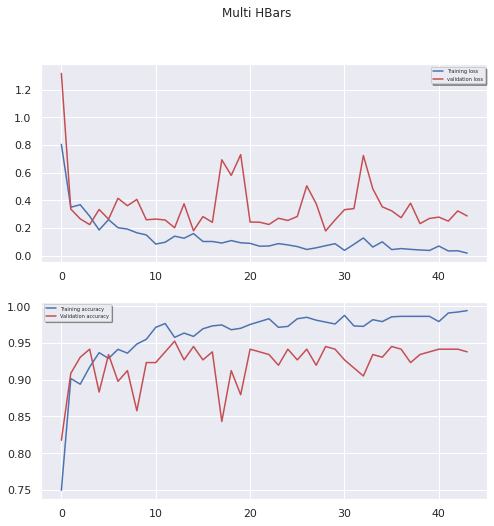

In [0]:
#figには全部、axはサブプロットがリストで返される
fig, ax = plt.subplots(2,1,figsize=(8,8))
fig.suptitle('Multi HBars')

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True,fontsize=5)

ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True,fontsize=5)

In [0]:
from sklearn import metrics
y_val_pred = model.predict(X_val)
#numpy配列化(必要に応じて)
# y_val_pred_numpy  = y_val_pred.iloc[:,1:5].values

#ROCのマクロモデル(多クラス)
metrics.roc_auc_score(y_val, y_val_pred, average='macro')

1.0

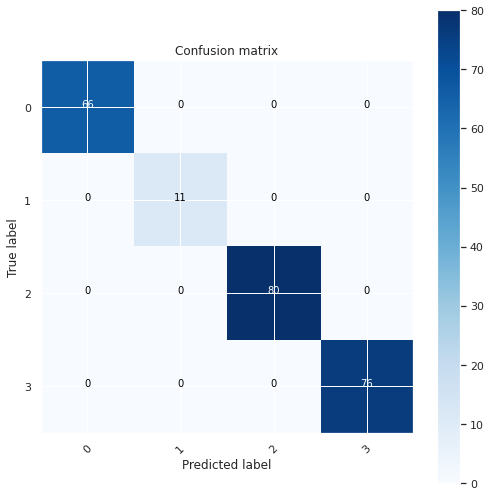

In [0]:
# plot the confusion matrix
def plot_confusion_matrix(y_train,y_train_pred_numpy,df_train,df_test):
  y_pred_classes_train = np.argmax(y_train_pred_numpy,axis = 1) 
  y_true = np.argmax(y_train,axis = 1) 
  confusion_mtx = confusion_matrix(y_true, y_pred_classes_train) 
  plt.figure(figsize=(7,7))
  targets = list(set(df_train.columns) ^ set(df_test.columns))
  target_classes = len(targets)
  # confusion_matrix with correlation map⇒外側の関数から内側の関数を読み込める
  def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      import itertools
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j],
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
  plot_confusion_matrix(confusion_mtx, classes = range(target_classes))

#実行
plot_confusion_matrix(y_val,y_val_pred,df_train,df_test)

In [0]:
(y_pred_classes_val - y_true_val != 0)

In [0]:
# Display some error results 

# Errors are difference between predicted labels and true labels⇒ブーリアン型のデータ
errors = (y_pred_classes_val - y_true_val != 0)

y_pred_classes_errors = y_pred_classes_val[errors]
y_pred_errors = y_pred_val[errors]
y_true_errors = y_true_val[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(8,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

# <font color="DeepPink">5.提出用データ

In [0]:
# 提出用データ生成
sub_id="image_id"
sub_target=['healthy', 'multiple_diseases', 'rust', 'scab']
sub_filename = "output2.csv"
test_data = datalist_test
# test_data = test_dataset
test_id = df_test.iloc[:,0]
test_predict = model.predict(test_data)
# test_predict = np.argmax(test_predict,axis = 1)
test_target = pd.DataFrame(test_predict,columns=sub_target)
test_Id = pd.DataFrame(test_id,columns=[sub_id])
pd.concat([test_Id, test_target],axis=1).to_csv(sub_filename,index=False)

In [0]:
# 提出用データ生成⇒平均
sub_id="image_id"
sub_target=['healthy', 'multiple_diseases', 'rust', 'scab']
sub_filename = "output_mean.csv"
test_data = test_dataset
test_id = df_test.iloc[:,0]

for i in range(len(test_predicts)):
  if i ==0:
    test_predict = test_predicts[i]/len(test_predicts)
  else:
    test_predict += test_predicts[i]/len(test_predicts)
# test_predict = np.argmax(test_predict,axis = 1)
test_target = pd.DataFrame(test_predict,columns=sub_target)
test_Id = pd.DataFrame(test_id,columns=[sub_id])
pd.concat([test_Id, test_target],axis=1).to_csv(sub_filename,index=False)

In [0]:
#コンペへ直接提出
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f "output_mean.csv" -m "ef_smote1"

100% 101k/101k [00:00<00:00, 332kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# 実験

In [0]:
a = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/sub/b_submission.csv")

In [0]:
z = a.copy()

In [0]:
a.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,3.377341e-06,8.916775e-04,9.998946e-01,0.000004
1,Test_1,2.612659e-05,4.449978e-04,9.997984e-01,0.000009
2,Test_2,5.343465e-07,1.268874e-05,6.669378e-08,0.749986
3,Test_3,7.499458e-01,9.711214e-07,1.310032e-05,0.000026
4,Test_4,5.049730e-06,5.641332e-04,9.996899e-01,0.000011


In [0]:
#1回目
max_num = a.iloc[:,1:5].values.argmax(axis = 1)
max_num

array([2, 2, 3, ..., 2, 0, 3])

In [0]:
for i,j in enumerate(max_num):
  a.iloc[i,j+1] = -100
  z.iloc[i,j+1] = 1.1

In [0]:
#2回目
max_num = a.iloc[:,1:5].values.argmax(axis = 1)
max_num

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
for i,j in enumerate(max_num):
  a.iloc[i,j+1] = -100
  z.iloc[i,j+1] = 0.05

In [0]:
#3回目
max_num = a.iloc[:,1:5].values.argmax(axis = 1)
max_num

array([3, 0, 0, ..., 0, 3, 0])

In [0]:
for i,j in enumerate(max_num):
  a.iloc[i,j+1] = -100
  z.iloc[i,j+1] = 0.002

In [0]:
#4回目
max_num = a.iloc[:,1:5].values.argmax(axis = 1)
max_num

array([0, 3, 2, ..., 3, 2, 2])

In [0]:
for i,j in enumerate(max_num):
  a.iloc[i,j+1] = -100
  z.iloc[i,j+1] = 0.001

In [0]:
z

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001,0.050,1.100,0.002
1,Test_1,0.002,0.050,1.100,0.001
2,Test_2,0.002,0.050,0.001,1.100
3,Test_3,1.100,0.001,0.002,0.050
4,Test_4,0.001,0.050,1.100,0.002
...,...,...,...,...,...
1816,Test_1816,0.001,0.050,1.100,0.002
1817,Test_1817,0.002,0.050,0.001,1.100
1818,Test_1818,0.002,0.050,1.100,0.001
1819,Test_1819,1.100,0.050,0.001,0.002


In [0]:
z.to_csv("soutai.csv",index=False)

# 6モデルの評価　ROCとconfusion_matric with heatmap
efficient net

In [0]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-ro2wucq_
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-ro2wucq_
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18327 sha256=5b746eaeb71e12d69abc66076789d78dd48beef97622ff6d91a6fbfd8cf6fa8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmrwvz4k/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [0]:
import efficientnet.tfkeras as efn

In [0]:
#modelの削除
try:
  del model
  print('ロードの前に既存のmodelを消したよ')
except:
  print('modelという変数は定義されてないよ')

#モデルのロード
load_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
file = "model_plant_ax2.h5"
model = load_model(os.path.join(load_path,file), compile=True)

modelという変数は定義されてないよ


In [0]:
%%time
y_train_pred = model.predict(X_train)

CPU times: user 26min 50s, sys: 13.2 s, total: 27min 4s
Wall time: 13min 52s


In [0]:
# y_pre= pd.DataFrame(y_train_predict)
# y_pre.to_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/y_pre.csv")
y_train_pred = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models/y_pre.csv").iloc[:,1:5].values

In [0]:
y_train_pred.max(axis=0)

array([1.       , 0.9999999, 1.       , 1.       ])

In [0]:
#行方向(列ごと)の合計が1になるように正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_pred_scaled = scaler.fit_transform(y_train_pred)
print(y_train_pred_scaled.max(axis=0))
y_train_pred_scaled

[1. 1. 1. 1.]


array([[8.82175000e-07, 6.11823761e-06, 1.05834650e-08, 9.99992970e-01],
       [1.08909486e-10, 4.28893673e-09, 7.46629900e-14, 1.00000000e+00],
       [3.53843830e-11, 1.96949690e-08, 1.00000000e+00, 1.80164990e-12],
       ...,
       [6.44630000e-10, 6.78074468e-07, 9.99999300e-01, 4.04989780e-09],
       [9.99999500e-01, 5.47640255e-08, 5.34394000e-07, 1.34642155e-08],
       [1.68895740e-10, 2.98078250e-08, 1.00000000e+00, 5.97944800e-11]])

In [0]:
#列方向(行ごと)の合計が1になるように正規化
def total1(y_train_pred):
 for i in range(len(y_train_pred)):
  if y_train_pred.sum(axis=1)[i] != 1:
   y_train_pred[i]/y_train_pred.sum(axis=1)[i]
 return y_train_pred
y_train_pred_total1 = total1(y_train_pred)
y_train_pred_total1

array([[8.82175016e-07, 6.11823134e-06, 1.05834648e-08, 9.99992967e-01],
       [1.08909277e-10, 4.28892788e-09, 7.46627085e-14, 1.00000000e+00],
       [3.53844488e-11, 1.96950047e-08, 1.00000000e+00, 1.80165334e-12],
       ...,
       [6.44631237e-10, 6.78075082e-07, 9.99999285e-01, 4.04990530e-09],
       [9.99999523e-01, 5.47641257e-08, 5.34394530e-07, 1.34642155e-08],
       [1.68896064e-10, 2.98078220e-08, 1.00000000e+00, 5.97944819e-11]],
      dtype=float32)

In [0]:
#行方向(列ごと)の合計が1になるように正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_pred_scaled = scaler.fit_transform(y_train_pred)
y_train_pred_scaled

array([[8.82175016e-07, 6.11823225e-06, 1.05834648e-08, 9.99992967e-01],
       [1.08909277e-10, 4.28892832e-09, 7.46627085e-14, 1.00000000e+00],
       [3.53844488e-11, 1.96950065e-08, 1.00000000e+00, 1.80165334e-12],
       ...,
       [6.44631237e-10, 6.78075139e-07, 9.99999285e-01, 4.04990530e-09],
       [9.99999523e-01, 5.47641328e-08, 5.34394530e-07, 1.34642155e-08],
       [1.68896064e-10, 2.98078255e-08, 1.00000000e+00, 5.97944819e-11]],
      dtype=float32)

[2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.9999964e-01
 9.9999952e-01 9.9999940e-01 9.9999928e-01 9.9999917e-01 9.9999905e-01
 9.9999893e-01 9.9999881e-01 9.9999833e-01 9.9999774e-01 9.9999762e-01
 9.9999714e-01 9.9999690e-01 9.9999666e-01 9.9999654e-01 9.9999559e-01
 9.9999535e-01 9.9999416e-01 9.9999404e-01 9.9998927e-01 9.9998915e-01
 9.9998319e-01 9.9998295e-01 9.9995494e-01 9.9995351e-01 8.4181505e-01
 8.3763200e-01 7.9099965e-01 7.8747284e-01 2.1961664e-01 1.0842809e-01
 2.5430903e-02 2.3230363e-02 1.2934617e-02 8.7695867e-26]
[1.9999999e+00 9.9999988e-01 9.9999964e-01 9.9999940e-01 9.9953711e-01
 9.9941909e-01 2.6934353e-01 2.6626819e-01 1.9941577e-01 1.0901353e-01
 4.9246449e-02 3.2506732e-03 3.1727876e-03 1.6517742e-04 1.6233297e-04
 1.5441527e-22]
[2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.9999964e-01
 9.9999952e-01 9.9999940e-01 9.9999928e-01 9.9999917e-01 9.9999905e-01
 9.9999893e-01 9.9999881e-01 9.9999869e-01 9.9999857e-01 9.9999845e-01
 9.

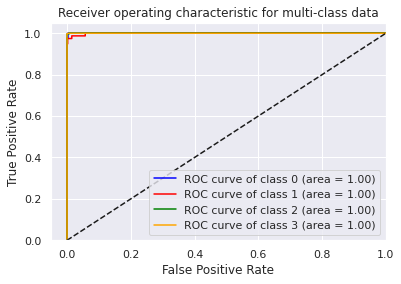

In [0]:
#ROC曲線y_true,y_predはnumpy配列にすること、threshould閾値は自動で算出される
from sklearn.metrics import roc_curve, auc
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()
thre = np.array([])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train[:, i], y_train_pred_total1[:, i])
    print(_)
    thre = np.append(thre,_,axis=0)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green',"orange"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [0]:
thre

array([2.0000000e+00, 1.0000000e+00, 9.9999990e-01, 9.9999976e-01,
       9.9999964e-01, 9.9999950e-01, 9.9999940e-01, 9.9999930e-01,
       9.9999917e-01, 9.9999905e-01, 9.9999890e-01, 9.9999880e-01,
       9.9999833e-01, 9.9999774e-01, 9.9999760e-01, 9.9999714e-01,
       9.9999690e-01, 9.9999666e-01, 9.9999654e-01, 9.9999560e-01,
       9.9999535e-01, 9.9999416e-01, 9.9999404e-01, 9.9998930e-01,
       9.9998915e-01, 9.9998320e-01, 9.9998295e-01, 9.9995494e-01,
       9.9995350e-01, 8.4181505e-01, 8.3763200e-01, 7.9099970e-01,
       7.8747284e-01, 2.1961664e-01, 1.0842812e-01, 2.5430903e-02,
       2.3230359e-02, 1.2934612e-02, 8.7695870e-26, 1.9999999e+00,
       9.9999990e-01, 9.9999964e-01, 9.9999940e-01, 9.9953710e-01,
       9.9941910e-01, 2.6934344e-01, 2.6626813e-01, 1.9941571e-01,
       1.0901350e-01, 4.9246450e-02, 3.2506746e-03, 3.1727876e-03,
       1.6517742e-04, 1.6233281e-04, 1.5441585e-22, 2.0000000e+00,
       1.0000000e+00, 9.9999990e-01, 9.9999976e-01, 9.9999964e

In [0]:
fpr

{0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.01713255e-04, 9.01713255e-04,
        1.80342651e-03, 1.80342651e-03, 2.70513977e-03, 2.70513977e-03,
        4.50856628e-03, 6.31199279e-03, 1.00000000e+00]),
 1: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.80735194e-04,
        6.80735194e-04, 2.04220558e-03, 2.04220558e-03, 1.49761743e-02,
        1.49761743e-02, 5.71817563e-02, 5.71817563e-02, 1.00000000e+00])

In [0]:
#ROCのマクロモデル(多クラス)
from sklearn import metrics
metrics.roc_auc_score(y_train, y_train_pred_scaled, average='macro')

0.9997303461947317

In [0]:
# confusion_matrix with correlation map
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

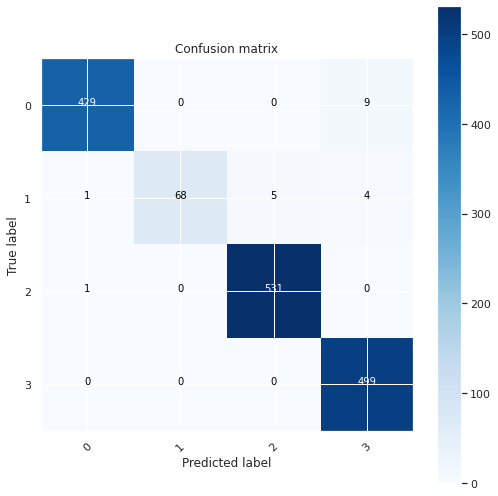

In [0]:
# plot the confusion matrix
y_pred_classes_train = np.argmax(y_train_pred_numpy,axis = 1) 
y_true = np.argmax(y_train,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes_train) 
plt.figure(figsize=(7,7))
targets = list(set(df_train.columns) ^ set(df_test.columns))
target_classes = len(targets)
plot_confusion_matrix(confusion_mtx, classes = range(target_classes)) 

### ROC関数化
- Densnet,VGG16で実験

In [0]:
#modelの削除
try:
  del model
  print('ロードの前に既存のmodelを消したよ')
except:
  print('modelという変数は定義されてないよ')

#モデルのロード
load_path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Plant Pathology/models"
file = "model_plant_a1_ex.h5"
model = load_model(os.path.join(load_path,file), compile=True)


ロードの前に既存のmodelを消したよ


In [0]:
from sklearn import metrics
y_train_pred_2 = model.predict(X_train)
#numpy配列化(必要に応じて)
# y_train_pred_numpy  = y_train_pred.iloc[:,1:5].values

#ROCのマクロモデル(多クラス)
metrics.roc_auc_score(y_train, y_train_pred_2, average='macro')

0.999998670050541

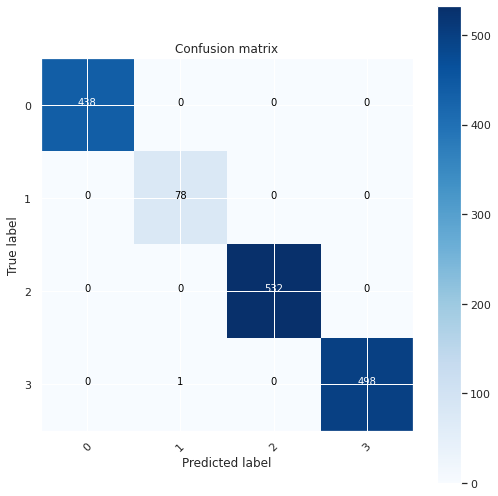

In [0]:
# plot the confusion matrix
y_pred_classes_train = np.argmax(y_train_pred,axis = 1) 
y_true = np.argmax(y_train,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes_train) 
plt.figure(figsize=(7,7))
targets = list(set(df_train.columns) ^ set(df_test.columns))
target_classes = len(targets)
plot_confusion_matrix(confusion_mtx, classes = range(target_classes)) 

In [0]:
#コメントアウト忘れずに↓
test_predicts = []
test_data = datalist_test

test_predicts.append(test_predict_x)
print(len(test_predicts))